### Initialize

In [1]:
# Define Program Version 
__ver__ = '01'

In [2]:
# Bunch of imports 
import therpy as tp
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
%matplotlib inline
import pandas as pd
import bec1db as bec1db_package
import warnings
from tqdm import tqdm_notebook as tqdm
warnings.filterwarnings("ignore")
import scipy.special
import os.path
import pickle
import ipywidgets as widgets
from IPython.display import display
import ipywidgets

cst = tp.cst(sigmaf=0.5)
kHz = cst.h * 1e3
twopi = np.pi * 2
bec1db = bec1db_package.Tullia(delta=20)

The servers are not connected!
Using the local database copy. Could be outdated!


In [189]:
# Bunch of functions 

def lorentzian_fitfun(f, f0, gamma, amp=1, offset=0):
    return amp * (gamma)**2 / ((f-f0)**2 + (gamma)**2) + offset

def gaussian(x, x0, sigma, amp, offset=0): return offset + amp*np.exp(- (x-x0)**2 / (2*sigma**2))

def bin_data(xi, yi):
    x = np.unique(xi)
    y = [None] * x.size
    for i in range(x.size): y[i] = yi[xi == x[i]]
    # Return 
    y_mean = np.array([a.mean() for a in y])
    y_err = np.array([np.std(a) / (a.size**0.5) for a in y])
    return (x, y_mean, y_err, y, xi, yi)

# returns rabi in kHz
@np.vectorize
def volt2rabi(volt):
    if volt < 0.1 or volt > 5:
        return 0
    volt = np.log10(volt)
    dbm = 1.5863 +0.2211*volt -0.1022*volt**2 -0.1301*volt**3 -0.0862*volt**4 +0.2323*volt**5 +0.1624*volt**6 -0.1552*volt**7 -0.1206*volt**8
    dbm = 10**dbm
    sqrtpwr = (10**((dbm-30)/10))**(1/2)
    return -0.0332 +0.5832*sqrtpwr -0.0167*sqrtpwr**2

from scipy.optimize import brentq
# Provide rabi in kHz
@np.vectorize
def rabi2volt(rabi):
    if rabi <= volt2rabi(0.1) or rabi >= volt2rabi(5):
        print('outside valid range')
        return 0
    def funSolve(v):
        return rabi - volt2rabi(v)
    return brentq(funSolve, 0.1, 5)
def meshgrid(xLen=10, yLen=10, data=None):
    if data is not None: yLen, xLen = data.shape
    return np.meshgrid(np.arange(xLen, dtype=np.float), np.arange(yLen, dtype=np.float))
def gaussian_2d(x, y, cx=1, cy=1, sx=1, sy=1, amp=1, offset=0, angle=0):
    x, y = x - cx, y - cy
    sx, sy = 2*sx**2, 2*sy**2
    a = angle * np.pi / 180
    xp, yp = x*np.cos(a) + y*np.sin(a), - x*np.sin(a) + y*np.cos(a)
    return offset + amp * np.exp(-xp**2/sx - yp**2/sy)
    
def gaussian_2d_guess(data, x=None, y=None):
    if x is None: x, y = np.meshgrid(np.arange(data.shape[1]), np.arange(data.shape[0]))
    t = np.sum(data)
    cx, cy = np.sum(data * x) / t, np.sum(data * y) / t
    sx, sy = (np.sum(data * (x-cx)**2) / t)**(1/2), (np.sum(data * (y-cy)**2) / t)**(1/2)
    return (cx, cy, sx, sy, data[int(cy), int(cx)], np.mean(data)/5, 0.0)
    
def fit_gaussian_2d(data, guess=None, plot=False):
    if guess is None: guess = gaussian_2d_guess(data)
    fr = tp.optimize.surface_fit(data, fun=gaussian_2d, guess=guess, show=plot)
    return fr
def gaussian_2d_integral(data, nsigma, fr=None, ideal=False, plot=False, guess=None, return_mask=False):
    if fr is None: fr = fit_gaussian_2d(data, guess=guess)
    # Generate the fitted data
    x, y = meshgrid(data=data)
    fit_data = gaussian_2d(x, y, *fr)
    amp = 1 if len(fr) <= 4 else fr[4]
    offset = 0 if len(fr) <= 5 else fr[5]
    # Ideal case
    if ideal:
        return np.sum(fit_data - offset)
    # Data case
    threshhold = np.exp(- nsigma**2/2) * amp + offset
    mask = fit_data >= threshhold
    # Plot
    if plot:
        plt.figure()
        plt.imshow(data)
        fit_data[~mask] = 0
        plt.imshow(mask, alpha=0.2, cmap='gray')
    
    # Mask return
    if return_mask:
        return mask
    
    return np.sum(data[mask])

''' 
Copy image names from clipboard and get parameters 
df : if you want to add on to the older df
init : initialize and return empty df
var : list of strings (variable names) that you want to retrive from database
x_var : a string (variable name), available as df.x
image_func : either tp.Image or tp.Hybrid_Image
using : 0=TopA only, 1=TopB only, 2=All Images
'''
def get_from_clipboard(df=None, init=False, var=None, x_var=None, image_func=tp.Image, using=2, display=False):
    # If initializing, then return empty dataframe
    if init: return pd.DataFrame(columns=['name','image'])
    
    # If df is None, make an empty one
    if df is None: 
        df = pd.DataFrame(columns=['name','image'])
    
    # Get the copied image names
    pasted = pd.read_clipboard(header=None, names=['name'])['name'].tolist()
    
    # Filter for using 0:TopA only, 1:TopB only, 2:all
    if using==0:
        pasted_filtered = [p for p in pasted if p[-1]=='A']
    elif using==1:
        pasted_filtered = [p for p in pasted if p[-1]=='B']
    else:
        pasted_filtered = [p for p in pasted]
    
    # Add it to df if not already in there
    names = df.name.tolist()
    for n in tqdm(pasted_filtered, desc='Loading'):
        if n not in names:
            df.loc[df.shape[0]] = n
            df.image[df.shape[0]-1] = image_func(name=n)
    
    # sort in time
    df.sort_values('name', inplace=True)
    df.reset_index(drop=True, inplace=True)
    
    # Get Parameters
    try: bec1db.refresh()
    except: pass
    df['shot'] = np.linspace(0,df.shape[0]/2-0.5,df.shape[0])
    if x_var is not None:
        df['x'] = bec1db.image_query(df.name.tolist(), [x_var])[x_var]
    if type(var) is str:
        df[var] = bec1db.image_query(df.name.tolist(), [var])[var]
    elif type(var) is list:
        _ = bec1db.image_query(df.name.tolist(), var)
        for n in var:
            df[n] = _[n]
    
    # Print Information
    if display:
        print('Pasted Sample : ', pasted[0:2])  
        print('Newly added images       : {}'.format(df.shape[0]- len(names)))
        print('Total number of images   : {}'.format(df.shape[0]))
    
    # return
    return df


def get_roi(data, center=[0,0], width=100, height=100):
    center = (data.shape[1]//2 + center[0], data.shape[0]//2 + center[1])
    return tp.imagedata.get_cropi(data, center=center, width=width, height=height)

def atom_num_filter(df_, keep = 0.15, offset = 0.0, plot=True):
    # Prepare
    if plot: fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(12,4))
    if plot: ax[0].plot(df_['shot'], df_['total_atoms']/1e6,'.-', label='All')
    shapes = [df_.shape]
    
    # Filter
    median_numbers = np.median(df_.total_atoms)
    offset += 1
    using = (df_.total_atoms.values > median_numbers*(offset-keep)) & (df_.total_atoms.values <= median_numbers*(offset+keep))
    bad = df_[~using] 
    df_ = df_[using]
    df_.reset_index(inplace=True, drop=True)
    shapes.append(df_.shape)
    if plot: ax[0].plot(bad['shot'], bad['total_atoms']/1e6, 'rx', label='Atom Num Filter')
    if plot: ax[0].axhline(median_numbers/1e6, linestyle='--', color='k', alpha=0.5)

    if plot: 
        # Plot
        median_numbers = np.median(df_.total_atoms)
        ax[1].plot(df_['shot'], df_['total_atoms']/median_numbers,'o-')
        ax[1].axhline(1, linestyle='--', color='k', alpha=0.5)

        ax[0].legend()
        ax[0].set(title = 'Atom number stability', xlabel= 'Shot Number ~ Time', ylabel='Atom Numbers [M]')
        ax[1].set(title = 'Median Atom Num {:.2f} M'.format(median_numbers/1e6), xlabel= 'Shot Number ~ Time', ylabel='Atom Numbers [median]')
        plt.tight_layout()

        # Relevant Information
        print('''
        Total Loaded Images {}
        Atom Num Filter     {}
        Removed Images      {}
        '''.format(shapes[0][0], shapes[1][0], shapes[0][0]-shapes[1][0]))
    
    return using

def erf(x, x0, sigma, amp=1):
    return amp * scipy.special.erf((x-x0)/(2**0.5 * sigma))

def mesh_for_2d_plot(x, y, z):
    x1 = np.concatenate([ [2*x[0] - x[1]], x])
    x2 = np.concatenate([x, [2*x[-1] - x[-2]]])
    x = np.mean([x1, x2], axis=0)

    y1 = np.concatenate([ [2*y[0] - y[1]], y])
    y2 = np.concatenate([y, [2*y[-1] - y[-2]]])
    y = np.mean([y1, y2], axis=0)
    
    return (x, y, z)

def fourier_transform(curve, k):
    return np.array([np.trapz(curve.y * np.exp(-1j * ki * curve.x) , curve.x) for ki in k])


'''
Least square curve fitting to {x,y} data 
========================================
Inputs Required : 
    fitfun - python function with inputs (of type x_data, p0, p1, p2, p3, ...) and returns np.array y_data 
    guess  - could be a simple list, or more detailed dict (see below for more info) 
    x_data - I think this could be anything supported by fitfun input, to be safe, keep it np.array 
    y_data - must be np.array 
    
Inputs Optional : 
    y_err - sigma for the y_data, defaults to np.ones_like(y_data). The following is optimized sum ( (y_data-fitfun(...))/y_err )^2
    fixed - dict(gradient = 0, tau = 5, ...) : parameters to fix. NOTE: if guess contains the same key, that key will not be fixed 
    plot  - True / False : Plots a standard figure with data, fit line, residuals 
    info  - True / False : prints fit results 

guess : recommended the third option 
    1) guess = [12, 3, -np.pi, ...] : a simple list 
    2) guess = [ [12, (10, 14), 'meter'], 3, [np.pi, (0, 2*np.pi)], ...] : mixture of simple value and fancy list 
    A fancy list for a guess contains up to three items -- the guess value itself, a tuple for lower and upper bounds, a string for units
    A fancy list must contain the guess itself, but the other two things are optional 
    3) guess = dict(tau = 12, phase = [np.pi, (0, 2*np.pi), 'radians'], ...) : a dictionary containing mixture of simple value and fancy list 

MUST DO : 
    - Make sure x_data, y_data, and y_err is valid for fitfun input/output and DOES NOT contain inf or nan. 

Properties : 
    fitresults : pandas dataframe of the fitresults 
    fitvalues : dict of fit values with parameters as keys, including the fixed and default parameters
    fiterrors : dict of fit errors with parameters as keys, including the fixed and default parameters
    fv : list of fit values, including the fixed and default parameters
    fe : list of fit errors, including the fixed and default parameters
    xp : finely spaced grid for same x range : np.linspace(self.x.min(), self.x.max(), 1000)
    
Special Methods : 
    __call__ : returns fitted curve at optionally provided x and overridden parameters : self(), self(x, phase=0, amp=0, ...), self(self.xp), 
    __len__ : len(self) returns the number of parameters the fitfun takes 
    __getitem__ : self['amp'] or self[1] : returns the fir value for given key or index 
    __setitem__ : self['amp'] = 0 or self[1] = 0 : fixes the 
    __bool__ : if self: or bool(self) : true if the fit was successful 
    __repr__ or __str__ : str(self) or print(self) : returns the fitresults in printable format 

Methods : 
    plot()
        two plots, data and fit curve on top, and residuals below. Optional inputs 
        ax : to plot somewhere specific
        fiterrors = False : include fit error band along with optimal fit 
        using = [] : which parameters to sue to calculate fiterrors band 
        divider = 0.25 : how to split the axes for residuals 
    plot_fitdata(ax=None) : data and fit curve 
    plot_residuals(ax=None) : residuals 
    plot_residuals_hist(ax=None, orientation='vertical) : histogram of the residuals 
    plot_fiterrors(ax=None, using=[]) : fit error band, optinally include only keys in using 
'''
import scipy.optimize

class Curve_Fit: 
    def __init__(self, fitfun, guess, x_data, y_data, y_err=None, fixed=dict(), plot=False, info=False): 
        ### Verify inputs 
        if not callable(fitfun): print("provided fitfun is not valid python function!")
        
        ### Process single item from guess -- return guess value, bounds, units 
        def temp_process_guess_item(item):
            units, bounds = None, [-np.inf, np.inf] # default value
            if type(item) in [list, tuple, np.ndarray]:
                value = item[0]
                if len(item) > 3: return [value, bounds, units]
                for i in item[1:]:
                    if type(i) is str: units = i
                    elif type(i) in [list, tuple, np.ndarray]: bounds = i
            else: value = item
            return [value, bounds, units]
        
        ### Process guess -- generate guess_keys, guess_values, guess_bounds, guess_units 
        # the order of keys will be determined by the order of fitfun input order 
        if type(guess) == dict:
            guess_keys = [k for k in fitfun.__code__.co_varnames[1:] if k in list(guess.keys())]
            temp_ = [temp_process_guess_item(guess[k]) for k in guess_keys]
        elif type(guess) in [list, tuple, np.ndarray]:
            guess_keys = fitfun.__code__.co_varnames[1:1+len(guess)]
            temp_ = [temp_process_guess_item(i) for i in guess]
        elif (type(guess) in [float, int]) or (np.issubdtype(guess, np.number)):
            guess_keys = fitfun.__code__.co_varnames[1:2]
            temp_ = [temp_process_guess_item(guess)]
        else:
            print('Does NOT understand data type of guess : ', guess)
        guess_values, guess_bounds, guess_units = np.array([i[0] for i in temp_]), np.array([i[1] for i in temp_]).T, [i[2] for i in temp_]
        
        ### Extract all fixed items, including provided and default ones
        fixed_func_defaults = {k:v for k, v in zip(fitfun.__code__.co_varnames[-len(fitfun.__defaults__):], fitfun.__defaults__)}
        fixed_dict = {**fixed_func_defaults, **fixed}
        for k in guess_keys: fixed_dict.pop(k, None)
        
        ### Define temp fitfun for internal use only 
        def fitfun_args(x, *args):
            return fitfun(x, **{k: v for k, v in zip(guess_keys, args)}, **fixed_dict)
        
        ### Fit Data 
        success = False
        try:
            fv_, fe_ = scipy.optimize.curve_fit(fitfun_args, x_data, y_data, guess_values, sigma=y_err, bounds=guess_bounds)
            fe_ = np.sqrt(np.diag(fe_))
            success = True
        except (ValueError, RuntimeError) as err: 
            fv_, fe_ = guess_values, guess_values*np.nan
            print("CAN'T FIT, Returning Original Guess: Details of Error :: {}".format(err))
            
        ### Formatting Fit Results 
        fitresults_dict = dict(FitValue=fv_, FitError=fe_, Units=guess_units, Guess=guess_values, LowerBound=guess_bounds[0], UpperBound=guess_bounds[1])
        fitresults_df = pd.DataFrame(fitresults_dict, index=guess_keys, columns=['FitValue','FitError','Units','Guess','LowerBound','UpperBound'])
        for k, v in fixed_dict.items(): fitresults_df.loc[k] = [v, 0, None, v, v, v]
        fitresults_df = fitresults_df.loc[fitfun.__code__.co_varnames[1:], :] # sort the index by function input list 
        fitresults_df['FitError%'] = np.nan_to_num(np.abs(fitresults_df['FitError'] / fitresults_df['FitValue'])) * 100
        
        ### Store results to self
        self.fitresults = fitresults_df
        self.fitfun = fitfun
        self.success = success
        self.x = x_data
        self.y = y_data
        self.y_err = y_err
        
        ### Plots and display 
        if plot: self.plot()
        if info: print(self)
    
    @property
    def fitvalues(self): return dict(self.fitresults['FitValue'])
    @property
    def fiterrors(self): return dict(self.fitresults['FitError'])
    @property
    def fv(self): return self.fitresults['FitValue'].values
    @property
    def fe(self): return self.fitresults['FitError'].values
    @property
    def xp(self): return np.linspace(self.x.min(), self.x.max(), 1000)
    
    def __call__(self, *args, **kwargs): 
        x = args[0] if len(args) == 1 else self.x
        return self.fitfun(x, **{**self.fitvalues, **kwargs})
    def __len__(self): return len(self.fv)
    def __getitem__(self, key): 
        if (type(key) in [int, float]): return self.fv[int(key)]
        elif type(key) == str: return self.fitvalues.get(key, None)
    def __setitem__(self, key, value): 
        if type(key) in [int, float]: key = self.fitresults.index.values[int(key)]
        r = self.fitresults.loc[key].values
        r[0], r[1], r[6] = value, 0, 0
        self.fitresults.loc[key] = r
    def __bool__(self): return self.success
    def __repr__(self): return self.fitresults.to_string()
    def __str__(self): return self.fitresults.to_string()
    
    def plot_fitdata(self, ax=None):
        if ax is None: fig, ax = plt.subplots()
        ax.errorbar(self.x, self.y, self.y_err, fmt='r.')
        ax.plot(self.xp, self(self.xp), 'k')
        return ax
    def plot_residuals(self, ax=None):
        if ax is None: fig, ax = plt.subplots()
        ax.axhline(0, c='k', alpha=0.5)
        ax.vlines(self.x, self.x*0, self.y-self())
        ax.plot(self.x, self.y-self(), 'r.')
        return ax
    def plot_residuals_hist(self, ax=None, orientation='vertical'):
        if ax is None: fig, ax = plt.subplots()
        ax.hist(self.y-self(), orientation=orientation)
        return ax
    def plot_fiterrors(self, ax=None, using=[]):
        ax = self.plot_fitdata(ax)
        xp = self.xp
        if type(using) == str: using = [using,]
        if len(using) == 0: using = self.fitresults.index.values
        ys = [self(xp)]
        for k in using:
            ys.append(self(xp, **{k : self.fitvalues[k] - self.fiterrors[k]}))
            ys.append(self(xp, **{k : self.fitvalues[k] + self.fiterrors[k]}))
        ax.fill_between(xp, np.min(ys, axis=0), np.max(ys, axis=0), color='g', alpha=0.25)
        return ax
    def plot(self, ax=None, fiterrors=False, using=[], divider=0.25):
        if ax is None: ax = plt.subplots(figsize=[5,5])[1]
        (ax1, ax2) = divide_axes(ax, divider=divider, direction='vertical', shared=True)
        if fiterrors: self.plot_fiterrors(ax1, using=using)
        else: self.plot_fitdata(ax1)
        self.plot_residuals(ax2)
        return (ax1, ax2)

# Additional Functions useful for general matplotlib axes creation 
'''
Adds a subplot inside a given axes 
==================================
Inputs -- all dimensions are in fractional sizes relative to the axes 
    ax : main axes 
    origin : location of the left bottom corner for the added subplot  
    width, height : width and height of the subplot 

Inputs Optional 
    bg = 'w' : the color for the background of the subplot, can't be transparent, because needs to cover the background 
    remove = False : remove the x,y-axis information from the parent axes 

Returns axes object of the subplot 
'''
def add_subplot_axes(ax, origin=[0.5,0.25], width=0.5, height=0.3, bg='w', remove=False):
    fig = ax.figure
    inax_position  = ax.transAxes.transform(origin)
    x, y = fig.transFigure.inverted().transform(inax_position)
    subax = fig.add_axes([x,y,ax.get_position().width*width,ax.get_position().height*height],facecolor=bg)
    if remove: ax.tick_params(axis='both', which='both', bottom=False, top=False, left=False, right=False, labelbottom=False, labelleft=False)
    return subax


'''
Divide an axes into two, horizontally or vertically 
===================================================
Inputs :
    ax : main axes 
    divider = 0.3 : fractional size for the bottom subplot 
    direction = 'vertical' : or 'horizontal' for division of the axes 
    shared = True : share the same x or y axis 

Returns (ax1, ax2) two subplot axes objects 
'''
def divide_axes(ax, divider=0.3, direction='vertical', shared=True):
    # Fractional Dimension for new axes  ; [origin_x, origin_y, width, height]
    if direction == 'horizontal':
        dim1 = [divider, 0, 1-divider, 1]
        dim2 = [0, 0, divider, 1]
    else:
        dim1 = [0, divider, 1, 1-divider]
        dim2 = [0, 0, 1, divider]
    # Add axes 
    ax1 = add_subplot_axes(ax, origin=dim1[0:2], width=dim1[2], height=dim1[3], bg='w', )
    ax2 = add_subplot_axes(ax, origin=dim2[0:2], width=dim2[2], height=dim2[3], bg='w', remove=True)
    # Adjust ticks for top (right) axes
    if direction == 'horizontal':
        ax1.tick_params(axis='y', which='both', direction='in', labelbottom=False, right=True)
        ax2.tick_params(axis='y', which='both', direction='in', right=True)
        if shared: ax1.get_shared_y_axes().join(ax1, ax2)
    else:
        ax1.tick_params(axis='x', which='both', direction='in', labelbottom=False, top=True)
        ax2.tick_params(axis='x', which='both', direction='in', top=True)
        if shared: ax1.get_shared_x_axes().join(ax1, ax2)
    # return
    return (ax1, ax2)

def makeplot_atomnum_time(ax, df_all, df=None, keep=None):
    if df is None: df = df_all
    if keep is None: 
        keep = (df.total_atoms.max() - df.total_atoms.mean()) / df.total_atoms.mean()
        keep = max(keep, (df.total_atoms.mean() - df.total_atoms.min()) / df.total_atoms.mean())
    using = np.array([i in df.index.values for i in df_all.index.values])
    ax.plot(df_all.shot, df_all.total_atoms/1e6, 'C0.-', 
            df_all[~using].shot, df_all[~using].total_atoms/1e6, 'rx')
    median_atom_num = np.median(df_all.total_atoms) / 1e6
    ax.axhline(median_atom_num, linestyle='-', c='k', alpha=0.5)
    ax.set(xlabel='Shot Number ~ Time', ylabel='Atom Number [Million]')
    ax.axhline(median_atom_num * (1 + keep), linestyle='--', c='k', alpha=0.5)
    ax.axhline(median_atom_num * (1 - keep), linestyle='--', c='k', alpha=0.5)
    ax.set(title='Fudge {}; Atom Num $\pm$ {:.0f}%;'.format(df.image.iloc[0].fudge, keep*100))
    

def makeplot_atomnum_hist(ax, df):
    ax.hist(df.total_atoms/1e6)
    mean_atom_num = np.mean(df.total_atoms)/1e6
    std_atom_num = np.std(df.total_atoms)/1e6
    ax.axvline(mean_atom_num, linestyle='-', c='k', alpha=0.5)
    ax.axvline(mean_atom_num + std_atom_num, linestyle='--', c='k', alpha=0.5)
    ax.axvline(mean_atom_num - std_atom_num, linestyle='--', c='k', alpha=0.5)
    ax.set(xlabel='Atom Number [Million]', ylabel='Histogram', title='Atom # {:.2f} $\pm$ {:.2f} M'.format(mean_atom_num, std_atom_num))

In [4]:
# Useful snippets 

default_settings = dict(
   # Image Preparation and Background 
   center_x=1110, center_y=1314, width=800, height=1000, 
   subsample=3, rotate=0, bg_width=20, bg_order=1, bad_light=0,

   # Physical Parameters
   Isat=77, time=10, pixel=0.7e-6, sigmaf=0.5, trap_f=23.9,
   od_method='table', fudge=1, ellipticity=1,
   
   # Hybrid Preparation
   xsec_extension='default', xsec_slice_width=4, 
   xsec_fit_range=1.75, radial_selection=0.5,
   
   # Hybrid Thermometry
   kind='unitary', Tfit_lim=0.06, Tfit_guess_kT=3, Tfit_guess_mu0=0, 
   
   # Other
   memory_saver=True, )



In [5]:
# Fermi Gas Classes 

# Import statements and useful functions 
import numpy as np
import pandas as pd
import therpy as tp
import scipy.optimize
import scipy.interpolate
import os.path
import os
import urllib.request

###### Parameters
cst_FG = tp.cst()
cst_FG.c1 = ((cst_FG.twopi * cst_FG.hbar**2)/(cst_FG.mass))**(1/2)
cst_FG.c2 = 1.0/(6*cst_FG.pi**2) * (2*cst_FG.mass/cst_FG.hbar**2)**(3/2)
cst_FG.virial_coef = [1.0, 3.0*2**(1/2)/8, -0.29095295, 0.065]
cst_FG.Critical_Temperature_TF = 0.17
cst_FG.xi = 0.37
cst_FG.xi_n = 0.45
def thermal_wavelength(kT):
    return cst_FG.c1 / (kT)**(1/2)
###### Ideal Gas
@np.vectorize
def density_ideal(kT, mu):
    if kT == 0:
        if mu <= 0:
            print('Density is undefined for negative mu and zero temperature')
            return 0.0
        return cst_FG.c2 * (mu)**(3/2)
    return thermal_wavelength(kT)**(-3) * tp.FermiFunction(m=3/2, logz=mu/kT)
@np.vectorize
def pressure_ideal(kT, mu):
    if kT == 0:
        return 2/5*density_ideal(0, mu)*mu
    return kT/thermal_wavelength(kT)**3 * tp.FermiFunction(m=5/2, logz=mu/kT)
@np.vectorize
def TTF_to_betamu_ideal(TTF, a=-10000, b=100):
    if TTF <= 0.01: return 1/TTF # Zero T approximation
    def minimizer(mu): return TTF - (cst_FG.h / cst_FG.n2EF(density_ideal(cst_FG.h, mu*cst_FG.h))) # Fix kT to 1 Hz and find mu in Hz (=betamu)
    return scipy.optimize.brentq(minimizer, a, b)   
@np.vectorize
def entropy_NkB_ideal(kT, mu):
    if kT == 0: return 0.0
    return (5/2 * tp.FermiFunction(m=5/2, logz=mu/kT) / tp.FermiFunction(m=3/2, logz=mu/kT)) - mu/kT
@np.vectorize
def entropy_NkB_TTF_ideal(TTF):
    if TTF == 0: return 0.0
    return entropy_NkB_ideal(cst_FG.h, TTF_to_betamu_ideal(TTF) * cst_FG.h)
###### Virial Gas
@np.vectorize
def density_virial(kT, mu):
    if kT == 0:
        return 0.0
    return kT / thermal_wavelength(kT)**3 * (cst_FG.virial_coef[0]*1/kT*np.exp(1*mu/kT) + cst_FG.virial_coef[1]*2/kT*np.exp(2*mu/kT) + cst_FG.virial_coef[2]*3/kT*np.exp(3*mu/kT) + cst_FG.virial_coef[3]*4/kT*np.exp(4*mu/kT) )
@np.vectorize
def pressure_virial(kT, mu):
    if kT == 0:
        return 0.0
    return kT / thermal_wavelength(kT)**3 * (cst_FG.virial_coef[0]*np.exp(1*mu/kT) + cst_FG.virial_coef[1]*np.exp(2*mu/kT) + cst_FG.virial_coef[2]*np.exp(3*mu/kT) + cst_FG.virial_coef[3]*np.exp(4*mu/kT) )

# Ideal Fermi Gas definition 
'''
Ideal Fermi Gas
    - functions to relate various Thermodynamic quantities

Methods
    - thermal_wavelength
    - density
    - pressure
    - TTF_to_betamu
    - entropy_NkB
    - entropy_NkB_TTF

Dataframe contains links between. Note that E = 3/2 PV
    - T/T_F
    - mu/E_F
    - P/P0 = E/E0
    - k/k0
    - Cv/Nk
    - S/Nk
'''
class Ideal_Fermi_Gas:
    def __init__(self, pts=1000, TTF_max = 200, TTF_min=0.05):
        # Define dataframe for fast computation
        kT = 1 * cst_FG.h
        mu = np.concatenate([np.linspace(self.TTF_to_betamu(TTF_max), 5, pts//10*9)[:-1], np.linspace(5, self.TTF_to_betamu(TTF_min), pts//10)]) * cst_FG.h
        n = self.density(kT, mu)
        P = self.pressure(kT, mu)
        EF = cst_FG.n2EF(n)
        P0 = self.pressure(0, EF)
        c1 = tp.Curve(x=mu, y=EF)
        df_ideal = pd.DataFrame(data=dict(betamu=mu/kT))
        df_ideal['T/T_F'] = kT / EF
        df_ideal['mu/E_F'] = mu / EF
        df_ideal['P/P0'] = P / P0
        df_ideal['k/k0'] = c1.diff(method='central2').y
        df_ideal['Cv/Nk'] = 3/2 * 1/df_ideal['T/T_F'] * (df_ideal['P/P0'] - 1/df_ideal['k/k0'])
        df_ideal['S/Nk'] = 1/df_ideal['T/T_F'] * (df_ideal['P/P0'] - df_ideal['mu/E_F'])
        self.df = df_ideal
    
    # Various functions
    def thermal_wavelength(self, kT): return thermal_wavelength(kT)
    def density(self, kT, mu): return density_ideal(kT, mu)
    def pressure(self, kT, mu): return pressure_ideal(kT, mu)
    def TTF_to_betamu(self, TTF, a=-10000, b=100): return TTF_to_betamu_ideal(TTF, a, b)
    def entropy_NkB(self, kT, mu): return entropy_NkB_ideal(kT, mu)
    def entropy_NkB_TTF(self, TTF): return entropy_NkB_TTF_ideal(TTF)

# Virial Fermi Gas Definition 
'''
Fermi Gas, Virial Expansion
'''
class Virial_Fermi_Gas:
    def __init__(self, TTF_max = 200, TTF_min=0.5):
        # Generate dataframe
        kT = 1 * cst_FG.h
        mu = np.linspace(TTF_to_betamu_ideal(TTF_max), TTF_to_betamu_ideal(TTF_min), 10000) * cst_FG.h
        n = self.density(kT, mu)
        P = self.pressure(kT, mu)
        EF = cst_FG.n2EF(n)
        P0 = pressure_ideal(0, EF)
        c1 = tp.Curve(x=mu, y=EF)
        df_virial = pd.DataFrame(data=dict(betamu=mu/kT))
        df_virial['T/T_F'] = kT / EF
        df_virial['mu/E_F'] = mu / EF
        df_virial['P/P0'] = P / P0
        df_virial['k/k0'] = c1.diff(method='central2').y
        df_virial['Cv/Nk'] = 3/2 * 1/df_virial['T/T_F'] * (df_virial['P/P0'] - 1/df_virial['k/k0'])
        self.df = df_virial
        
    # Various functions
    def thermal_wavelength(self, kT): return thermal_wavelength(kT)
    def density(self, kT, mu): return density_virial(kT, mu)
    def pressure(self, kT, mu): return pressure_virial(kT, mu)
    

# Unitary Fermi Gas using Mark's EoS 
'''
Mark's equation of state
'''
class Unitary_Fermi_Gas: 
    def __init__(self,):
        # Download the data if not already
        p_ = tp.getpath('Projects','Data','EoS','UnitaryFermiGasExperiment_kPEoS.csv')
        if not os.path.isfile(p_):
            print("Downloading Database -- Might take some time!")
            url = 'https://www.dropbox.com/s/8irmfrn2zdvfgba/UnitaryFermiGasExperiment_kPEoS.csv?dl=1'
            u = urllib.request.urlopen(url)
            data = u.read()
            u.close()
            # Create folder
            os.makedirs(os.path.split(p_)[0], exist_ok=True)
            with open(p_, "wb") as f :
                f.write(data)
        
        # Load Data
        self.df = pd.read_csv(p_)
        
        # Interpolated Density Data
        x = np.array(self.df['T/T_F'])
        y = np.array(self.df['mu/E_F'])
        VFG = Virial_Fermi_Gas()
        c = tp.Curve(x = np.array(VFG.df['T/T_F']), y = np.array(VFG.df['mu/E_F'])).sortbyx().trim(xlim=[np.max(x),np.max(x)+0.1])
        muEF_curve = tp.Curve(x = np.concatenate([[0], x, c.x]), y = np.concatenate([[cst_FG.xi], y, c.y]))
        TTF = np.linspace(0, muEF_curve.maxx, 10000)
        muEF = muEF_curve(TTF)
        c_muEF_extension = tp.Curve(TTF, muEF)
        density_c_low = scipy.interpolate.interp1d(x = TTF / muEF, y = muEF)
        density_c_high = scipy.interpolate.interp1d(x = muEF[1:] / TTF[1:], y = muEF[1:])
        self.density_c_low = density_c_low
        self.density_c_high = density_c_high
        self.density = np.vectorize(self.density_single)
        
        # Interpolated Energy Data
        IFG = Ideal_Fermi_Gas()
        c1 = tp.Curve(np.array(self.df['T/T_F']), np.array(self.df['E/E0'])) # Mark EoS E/E0 vs T/T_F
        c2 = tp.Curve(np.array(IFG.df['T/T_F']), np.array(IFG.df['P/P0'])).trim(xlim=[c1.maxx + 0.2, np.inf]) # Ideal Fermi Gas E/E0 = P/P0 vs T/T_F, from end of Mark EoS to end with some padding for smooth transition
        energy_c = scipy.interpolate.interp1d(x = np.concatenate([[0], c1.x, c2.x]), y = np.concatenate([[cst_FG.xi], c1.y, c2.y+(cst_FG.xi_n-1)]))
        self.energy_c = energy_c
        self.IFG = IFG
        self.E_E0 = np.vectorize(self.E_E0_single)
        
    # Various functions
    def density_single(self, kT, mu):
        # Zero T
        if kT == 0:
            return cst_FG.EF2n(mu/cst_FG.xi, neg=True)
        if mu/kT > 4:
            return cst_FG.EF2n(mu / self.density_c_low(kT/mu), neg=True)
        if mu/kT > -0.5:
            return cst_FG.EF2n(mu / self.density_c_high(mu/kT), neg=True)
        return density_virial(kT, mu)
    
    def density_hybrid(self, z, kT, mu, trapf=23.9):
        return self.density(kT, mu - 1/2 * cst_FG.mass * (2*np.pi*trapf)**2 * z**2)
    
    def E_E0_single(self, TTF):
        if TTF < self.energy_c.x.max():
            return self.energy_c(TTF)
        else:
            # Compute using IFG
            # betamu = self.IFG.TTF_to_betamu(TTF)
            # return (self.IFG.pressure(cst_FG.h, betamu * cst_FG.h) / self.IFG.pressure(0, betamu * cst_FG.h)) + (cst_FG.xi_n-1)
            return self.energy_c.y[-1]

# Make objects
IFG = Ideal_Fermi_Gas()
VFG = Virial_Fermi_Gas()
UFG = Unitary_Fermi_Gas()

# Special Functions
def hybrid_E_N(kT, mu, trapf=23.35, simple=True, nz = None):
    u_ = 1/2 * cst_FG.mass * (2*np.pi*trapf)**2
    if nz is None:
        n_0 = UFG.density(kT, mu)
        z_max = 0
        while True:
            z_max += 50e-6
            if UFG.density(kT, mu - u_*z_max**2) <= n_0 / 1e6: break
        z = np.linspace(-z_max, z_max, z_max*1e6 * 4)
        n = UFG.density(kT, mu - u_* z**2)
    else:
        z = nz.x
        n = nz.y
        
    if simple: # If simple, then simply return 4 * <U>
        return 4 * np.trapz(u_*z**2 * n, z) / np.trapz(n, z)
    
    # Compute total E_int + U energy
    EF = cst_FG.n2EF(n)
    TTF = kT / EF
    E_N_z = UFG.E_E0(TTF) * 3/5 * EF
    E_N = (np.trapz(E_N_z * n, z) + np.trapz(u_*z**2 * n, z)) / np.trapz(n, z)
    return E_N

# Special Functions
def hybrid_total_atoms(kT, mu, trapf=23.35, cross_section=np.pi*(58e-6)**2):
    u_ = 1/2 * cst_FG.mass * (2*np.pi*trapf)**2
    n_0 = UFG.density(kT, mu)
    z_max = 0
    while True:
        z_max += 50e-6
        if UFG.density(kT, mu - u_*z_max**2) <= n_0 / 1e6: break
    z = np.linspace(-z_max, z_max, z_max*1e6 * 4)
    n = UFG.density(kT, mu - u_* z**2)
    N = np.trapz(n, z) * cross_section
    return N

# In Situ Density Modulation

In [6]:
# Some Fitting functions 
import scipy.special
def erf(x, x0, sigma, amp=1):
    return amp * scipy.special.erf((x-x0)/(2**0.5 * sigma))
def fitfun_erf(x, x1, x2, s1, s2, amp=1, offset=0, slope=0):
    y = erf(x, x1, s1) + erf(-x, -x2, s2)
    return y*amp/2 + offset + slope*x

In [7]:
# Desplay widgets to select various parameters 

# All the variables to load 
var = ['ExpansionTime','SideGreenEvap','WaitBox',
       'IREvap','HeatTime','ShakeTime','ShakeWait', 'HeatCycles',
       'ShakingCycles', 'BoxShakeFreq','BoxShakeAmp','BoxShakeTime',
       'SeqMode']

fontsize = 15

# Saving and Loading widgets 
WID_SaveAnalyzedDataBtn = widgets.Button( description='Save Data', button_style='success', )
WID_Folder = widgets.Text( value='AnalyzedData', placeholder='Type Folder to store data', description='Save Folder :')
WID_DatasetType = widgets.Text( value='InsituShakingVsFreq', placeholder='Type Dataset Type/Information', description='Dataset Type :',)
WID_DatasetDate = widgets.Text( value='06_22_2017', placeholder='Type Dataset Date, E.x. 06_15_2017', description='Dataset Date :',)
WID_DatasetName = widgets.Text( value='DS3', placeholder='Type Dataset Name, E.x. DS1', description='Dataset Name :',)

# Select a Particular x_variable
WID_x_var = widgets.ToggleButtons(description='x variable = = > ', 
            options=['ShakeWait', 'ShakingCycles', 'BoxShakeFreq', 'BoxShakeAmp', 'HeatCycles'])
display(WID_x_var)

# Select a Particular x_variable
WID_using_image = widgets.ToggleButtons(description='Image Selection = = > ', 
            options=['A', 'B', 'Both'])
display(WID_using_image)

# Select a Particular X_Label for the plots 
WID_xlabel = widgets.ToggleButtons(description='xlabel for plots = > ', 
            options=['Waittime (ms)', 'Shaking Cycles', 'Shaking Frequency (Hz)', 'Shaking Amplitude (Cicero Volts)', 'Heating Cycles'])
display(WID_xlabel)

# Reduced Plots and Info for Faster Processing 
WID_info = widgets.Checkbox( value=True, description='Show all info plots',)
display(WID_info)

# Additional WID used later 
WID_atoms_keep = widgets.FloatSlider(value=0.07, min=0.01, max=0.4, step=0.01,
                description='Atom Num Selection:', readout=True, readout_format='.2f',
                layout=widgets.Layout(width='50%'), )

WID_height = widgets.IntSlider(value=181, min=105, max=219, step=2,
             description='Height:', readout=True, layout=widgets.Layout(width='50%'), )

WID_width = widgets.IntSlider(value=75, min=15, max=177, step=2,
             description='Width:', readout=True, layout=widgets.Layout(width='50%'), )

WID_center_x = widgets.IntSlider(value=0, min=-30, max=30, step=1,
             description='Center X:', readout=True, layout=widgets.Layout(width='50%'), )

WID_center_y = widgets.IntSlider(value=0, min=-30, max=30, step=1,
             description='Center Y:', readout=True, layout=widgets.Layout(width='50%'), )

WID_clim_dN = widgets.FloatSlider(value=0.15, min=0.01, max=0.50, step=0.001,
                description='clim for dN:', readout=True, readout_format='.3f',
                layout=widgets.Layout(width='50%'), )

WID_clim_dN_N = widgets.FloatSlider(value=0.15, min=0.01, max=0.5, step=0.001,
                description='clim for dN/N:', readout=True, readout_format='.3f',
                layout=widgets.Layout(width='50%'), )

In [8]:
# ONLY ONCE -- Initialize empty dataframe and select options 
df_all = get_from_clipboard(init=True)

## Load Data from Images

In [9]:
# Import from Clipboard 
x_var = WID_x_var.value
using = 0 if WID_using_image.value == 'A' else 1 if WID_using_image.value == 'B' else 2
info = WID_info.value
df_all = get_from_clipboard(df=df_all, init=False, var=var, x_var=x_var, image_func=tp.Hybrid_Image, using=using, display=info)

if WID_info.value:
    df_all.head(5) 


Pasted Sample :  ['07-18-2017_21_59_48_TopA', '07-18-2017_21_59_48_TopB']
Newly added images       : 334
Total number of images   : 334


07-18-2017_21_40_29_TopA
0.0


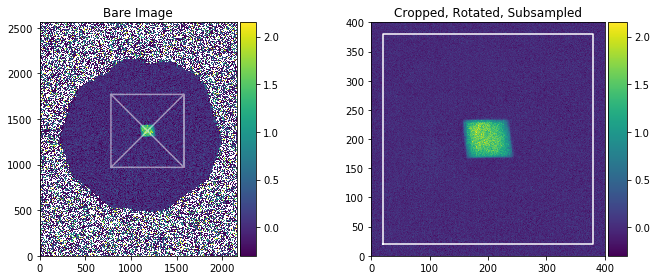

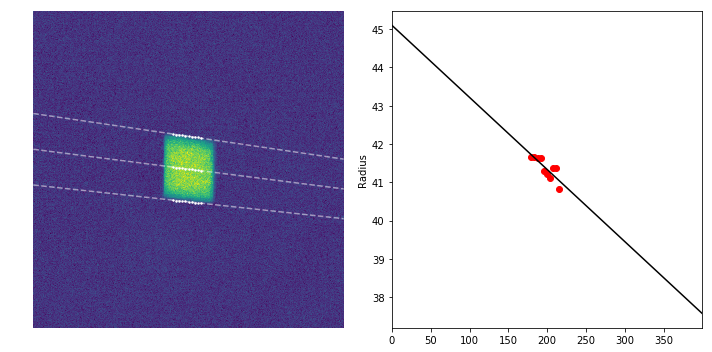

In [16]:
# Define Settings 
settings = {**default_settings, 
            **dict(center_x = 1181, center_y = 1370, width=800, height=800, fudge=1.75, subsample=2, 
                  xsec_extension='linear', xsec_slice_width=4, xsec_fit_range=1.0, radial_selection=0.8,)}

# Apply settings
for i, r in df_all.iterrows():
    r.image.set(**settings)
    
# Tests
if WID_info.value: 
    test = 0
    print(df_all.image.iloc[test].name)
    df_all.image.iloc[test].plot_crop()
    print(df_all.x.iloc[test])
    plt.show()
    fig, ax = plt.subplots(ncols=2, figsize=[10, 5])
    df_all.image.iloc[test].xsec.infoplot(axs=ax)
    plt.tight_layout()

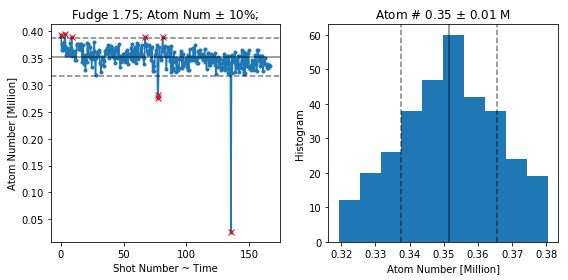

In [18]:
# Atom Number Filter 

# Parameters 
display(WID_atoms_keep)
df_all['total_atoms'] = [im.total_atoms for im in tqdm(df_all.image, desc='Atoms')]
using = atom_num_filter(df_all, keep=WID_atoms_keep.value, offset=0.0, plot=False)
df = df_all[using]

def makeplot_atomnum_time(ax, df_all=df_all, using=using):
    ax.plot(df_all.shot, df_all.total_atoms/1e6, 'C0.-', 
            df_all[~using].shot, df_all[~using].total_atoms/1e6, 'rx')
    median_atom_num = np.median(df_all.total_atoms) / 1e6
    ax.axhline(median_atom_num, linestyle='-', c='k', alpha=0.5)
    ax.axhline(median_atom_num * (1 + WID_atoms_keep.value), linestyle='--', c='k', alpha=0.5)
    ax.axhline(median_atom_num * (1 - WID_atoms_keep.value), linestyle='--', c='k', alpha=0.5)
    ax.set(xlabel='Shot Number ~ Time', ylabel='Atom Number [Million]', 
              title='Fudge {}; Atom Num $\pm$ {:.0f}%;'.format(df.image.iloc[0].fudge, WID_atoms_keep.value*100))

def makeplot_atomnum_hist(ax, df=df):
    ax.hist(df.total_atoms/1e6)
    mean_atom_num = np.mean(df.total_atoms)/1e6
    std_atom_num = np.std(df.total_atoms)/1e6
    ax.axvline(mean_atom_num, linestyle='-', c='k', alpha=0.5)
    ax.axvline(mean_atom_num + std_atom_num, linestyle='--', c='k', alpha=0.5)
    ax.axvline(mean_atom_num - std_atom_num, linestyle='--', c='k', alpha=0.5)
    ax.set(xlabel='Atom Number [Million]', ylabel='Histogram', title='Atom # {:.2f} $\pm$ {:.2f} M'.format(mean_atom_num, std_atom_num))

fig, ax = plt.subplots(ncols=2, figsize=[8, 4])
makeplot_atomnum_time(ax[0], df_all, using)
makeplot_atomnum_hist(ax[1], df)
plt.tight_layout()

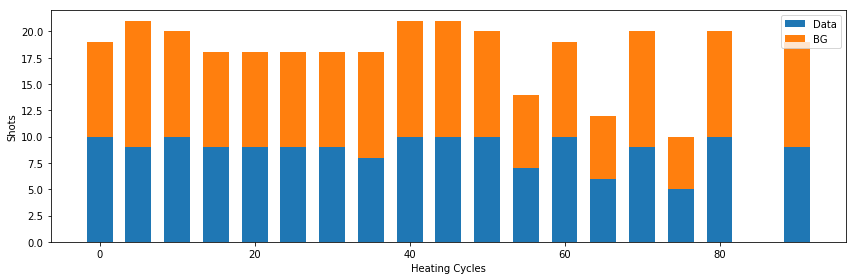

In [19]:
# Dataset Explorer 
bg_variable = 'ShakingCycles'
bg_value = 0

# Count number of images 
unique_x = np.unique(df.x)
data_counts = np.array([np.sum(df.x[df[bg_variable] != bg_value].values == x) for x in unique_x])
bg_counts = np.array([np.sum(df.x[df[bg_variable] == bg_value].values == x) for x in unique_x])
dataset_counter = [unique_x, data_counts, bg_counts]

# Plot counter 
def makeplot_dataset_counter_barchart(ax, count = dataset_counter):
    if len(count[0]) > 1: width = np.min(np.diff(count[0]))/1.5
    else: width = 1
    ax.bar(count[0], count[1], width, label='Data')
    ax.bar(count[0], count[2], width, bottom=count[1], label='BG')
    ax.legend()
    ax.set(xlabel = WID_xlabel.value, ylabel='Shots')
    
fig, ax = plt.subplots(figsize=[12, 4])
makeplot_dataset_counter_barchart(ax)
plt.tight_layout()

In [13]:
# # SAME BG : Compute df_data : delta_rho and delta_rho_rho for datasets with both bg and data images with some threshold 

# # inputs 
# threshold_image_num = 1

# # n(z) 
# df['nz_raw'] = [im.nz for im in tqdm(df.image, desc='n(z)')]

# # Fitting erf to get center and box length 
# guess = [-50e-6, 50e-6, 5e-6, 5e-6, 0.6e18, 1e15, ]
# def fitfun_erf_2(x, x1, x2, s1, s2, amp=1, offset=0, slope=0):
#     y = erf(x, x1, s1) + erf(-x, -x2, s2)
#     return y*amp/2 + offset + slope*x
# df['fitres_erf'] = [nz.fit(fitfun_erf_2, guess)[0] for nz in df.nz_raw]

# # Get the background profile 
# bg_ind = (df[bg_variable] == bg_value)
# length = np.mean([fr[1] - fr[0] for fr in df.fitres_erf[bg_ind]])
# amp = np.mean([fr[4] for fr in df.fitres_erf[bg_ind]])
# nz_bg_all = [tp.Curve(r.nz_raw.x - r.fitres_erf[1] + length, 
#     (r.nz_raw.y - r.fitres_erf[5]) * amp / r.fitres_erf[4]) for i, r in df[bg_ind].iterrows()]
# nz_bg_concat = tp.Curve(np.concatenate([nz.x for nz in nz_bg_all]), np.concatenate([nz.y for nz in nz_bg_all])).sortbyx()
# nz_bg = nz_bg_concat.binbyx(step = np.diff(df.iloc[0].nz_raw.x)[0])

# # Process particular x 
# def process_particular_x(x, ):
#     # collect bg and data ind for this x 
#     data_ind = (df[bg_variable] != bg_value) & (df.x == x)
    
#     # compute parameters 
#     freq = np.unique(df.BoxShakeFreq[data_ind])[0]
#     cycles = np.unique(df.ShakingCycles[data_ind])[0]
    
#     # Get all nz
#     nz_data_all = [tp.Curve(r.nz_raw.x - r.fitres_erf[1] + length, 
#              (r.nz_raw.y - r.fitres_erf[5]) * amp / r.fitres_erf[4]) for i, r in df[data_ind].iterrows()]
    
#     # Average nz 
#     nz_data_concat = tp.Curve(np.concatenate([nz.x for nz in nz_data_all]), np.concatenate([nz.y for nz in nz_data_all])).sortbyx()
#     nz_data = nz_data_concat.binbyx(step = np.diff(df.iloc[0].nz_raw.x)[0])
    
#     # compute delta rho 
#     x = nz_bg.x.copy()
#     delta_rho = tp.Curve(x, nz_data(x) - nz_bg(x))
#     delta_rho_rho = tp.Curve(x, (nz_data(x) - nz_bg(x))/nz_bg(x) )
    
#     # return 
#     return (delta_rho, delta_rho_rho, nz_data, nz_bg, nz_data_all, 
#             nz_bg_all, length, amp, np.sum(data_ind), 
#             np.sum(bg_ind), freq, cycles)
    

# # df_data 
# df_data = pd.DataFrame(columns=['Delta rho', 'Delta rho / rho', 'nz data', 
#                                 'nz bg', 'nz data all', 'nz bg all', 'length', 
#                                 'amp', '# data', '# bg', 'freq', 'cycles'])
# for i, x in enumerate(dataset_counter[0]):
#     if (dataset_counter[1][i] >= threshold_image_num):
#         df_data.loc[x] = process_particular_x(x)
        

In [20]:
# SEPARATE BG : Compute df_data : delta_rho and delta_rho_rho for datasets with both bg and data images with some threshold 

# inputs 
threshold_image_num = 1

# n(z) 
df['nz_raw'] = [im.nz for im in tqdm(df.image, desc='n(z)')]

# Fitting erf to get center and box length 
guess = [-50e-6, 50e-6, 5e-6, 5e-6, 0.6e18, 1e15, ]
def fitfun_erf_2(x, x1, x2, s1, s2, amp=1, offset=0, slope=0):
    y = erf(x, x1, s1) + erf(-x, -x2, s2)
    return y*amp/2 + offset + slope*x
df['fitres_erf'] = [nz.fit(fitfun_erf_2, guess)[0] for nz in df.nz_raw]

# Process particular x 
def process_particular_x(x, ):
    # collect bg and data ind for this x 
    bg_ind = (df[bg_variable] == bg_value) & (df.x == x)
    data_ind = (df[bg_variable] != bg_value) & (df.x == x)
    
    # compute parameters 
    length = np.mean([fr[1] - fr[0] for fr in df.fitres_erf[bg_ind]])
    amp = np.mean([fr[4] for fr in df.fitres_erf[bg_ind | data_ind]])
    freq = np.unique(df.BoxShakeFreq[bg_ind | data_ind])[0]
    cycles = np.unique(df.ShakingCycles[bg_ind | data_ind])[0]
    
    # Get all nz
    nz_bg_all = [tp.Curve(r.nz_raw.x - r.fitres_erf[1] + length, 
             (r.nz_raw.y - r.fitres_erf[5]) * amp / r.fitres_erf[4]) for i, r in df[bg_ind].iterrows()]
    nz_data_all = [tp.Curve(r.nz_raw.x - r.fitres_erf[1] + length, 
             (r.nz_raw.y - r.fitres_erf[5]) * amp / r.fitres_erf[4]) for i, r in df[data_ind].iterrows()]
    
    # Average nz 
    nz_bg_concat = tp.Curve(np.concatenate([nz.x for nz in nz_bg_all]), np.concatenate([nz.y for nz in nz_bg_all])).sortbyx()
    nz_data_concat = tp.Curve(np.concatenate([nz.x for nz in nz_data_all]), np.concatenate([nz.y for nz in nz_data_all])).sortbyx()
    nz_bg = nz_bg_concat.binbyx(step = np.diff(df.iloc[0].nz_raw.x)[0])
    nz_data = nz_data_concat.binbyx(step = np.diff(df.iloc[0].nz_raw.x)[0])
    
    # compute delta rho 
    x = nz_bg.x.copy()
    delta_rho = tp.Curve(x, nz_data(x) - nz_bg(x))
    delta_rho_rho = tp.Curve(x, (nz_data(x) - nz_bg(x))/nz_bg(x) )
    
    # return 
    return (delta_rho, delta_rho_rho, nz_data, nz_bg, nz_data_all, 
            nz_bg_all, length, amp, np.sum(data_ind), 
            np.sum(bg_ind), freq, cycles)
    

# df_data 
df_data = pd.DataFrame(columns=['Delta rho', 'Delta rho / rho', 'nz data', 
                                'nz bg', 'nz data all', 'nz bg all', 'length', 
                                'amp', '# data', '# bg', 'freq', 'cycles'])
for i, x in enumerate(dataset_counter[0]):
    if (dataset_counter[1][i] >= threshold_image_num) and (dataset_counter[2][i] >= threshold_image_num):
        df_data.loc[x] = process_particular_x(x)
        

## FT Wavelength 

In [107]:
# FT Setup 
L = np.mean(df_data.length)
k = np.arange(0, 30*twopi/L, 0.1*twopi/L)
use = 'Delta rho / rho'
# use = 'Delta rho'
z_lims = np.array([18, 60]) * 1e-6
speed_sound_guess = 17.5 * 1e-6/1e-3
test = 0

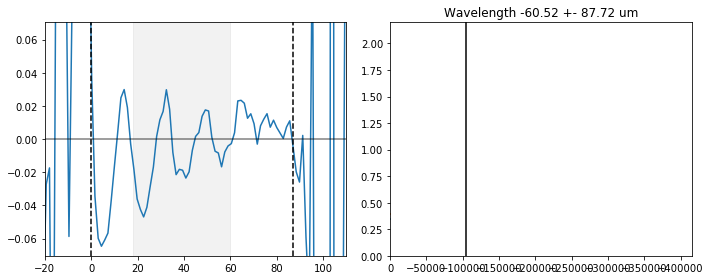

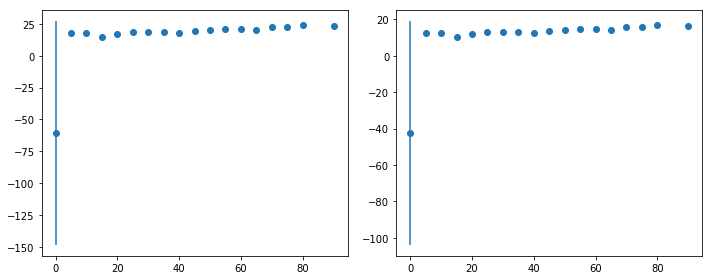

In [108]:
# Compute Wavelength for all 

def fitfun(x, x0=0, amp=1, scale=1, offset=0, gradient=0):
    return amp * np.abs(np.sinc((x-x0) / scale)) + offset + gradient * x 

wavelengths = []

for x, r in df_data.iterrows():
    # Get FT 
    c = r[use].trim(xlim=z_lims)
    y_ft = fourier_transform(c, k)
    c_ft = tp.Curve(k, np.abs(y_ft) * 1e6)
    
    # Fit Sinc 
    guess = [twopi*r.freq / speed_sound_guess, c_ft.y.max(), twopi / (z_lims[1] - z_lims[0]), c_ft.maxy / 1000, c_ft.maxy / 100000]
    fit_lims = [guess[0] - 3 * twopi/L, guess[0] + 3 * twopi/L]
    fr, fe = c_ft.fit(fitfun, guess, plot=False, xlim=fit_lims)
    
    # Extract wavelength and error 
    wavelengths.append([twopi*1e6/fr[0], twopi*1e6 * fe[0]/fr[0]**2])
wavelengths = np.array(wavelengths)

## Test Plotter 
# Get test 
r = df_data.iloc[test]

# Get FT 
c = r[use].trim(xlim=z_lims)
y_ft = fourier_transform(c, k)
c_ft = tp.Curve(k, np.abs(y_ft) * 1e6)

# Fit Sinc 
guess = [twopi*r.freq / speed_sound_guess, c_ft.y.max(), twopi / (z_lims[1] - z_lims[0]), c_ft.maxy / 1000, c_ft.maxy / 100000]
fit_lims = [guess[0] - 3 * twopi/L, guess[0] + 3 * twopi/L]
fr, fe = c_ft.fit(fitfun, guess, plot=False, xlim=fit_lims)

plt.figure(figsize=[10, 4])
plt.subplot(121)
plt.plot(r[use].x*1e6, r[use].y)
plt.axvline(0, c='k', linestyle='--', )
plt.axvline(L*1e6, c='k', linestyle='--', )
plt.axhline(0, c='k', linestyle='-', alpha=0.5)
plt.axvspan(*z_lims*1e6, alpha=0.05, color='k', label='Fourier Width')
amp = np.max(np.abs(c.y)) * 1.5
plt.ylim([-amp, amp])
plt.xlim([-20, 110])

plt.subplot(122)
plt.plot(*c_ft.data)
plt.plot(*c_ft.xyfitplot)
plt.axvline(fr[0], c='k',)
plt.axvspan(*fit_lims, alpha=0.05, color='k', label='Fourier Width')
plt.ylim([0, None])
plt.xlim([0, fr[0]*4])
plt.title('Wavelength {:.2f} +- {:.2f} um'.format(twopi*1e6/fr[0], twopi*1e6 * fe[0]/fr[0]**2))
plt.tight_layout()

## Data Plotter 
plt.figure(figsize=[10, 4])
plt.subplot(121)
plt.errorbar(df_data.index.values, wavelengths[:, 0], wavelengths[:, 1], fmt='o')
plt.subplot(122)
plt.errorbar(df_data.index.values, df_data.freq.values*wavelengths[:, 0]/1e3, df_data.freq.values*wavelengths[:, 1]/1e3, fmt='o')
plt.tight_layout()

## Single Sided Decay Fits

In [165]:
# Dataset Info 
speed_sound_guess = 15 * 1e-6/1e-3
fit_lims = [12, 60]
plot_lims = [-10, 100]

In [180]:
# Single Sided Fit -- 0:InvDevayLength, 1:Wavelength, 2:Amplitude, 3:Phase, 4:Offset, 5:Gradient, 6:speed, 7:gamma 
def single_analyzer(c, freq, fit_lims, guess_wavelength, plot=False, plot_lims=[-10, 100], plot_res = False, phase=np.pi): 
    # Fit Exp Decay 
    guess = [0, guess_wavelength, c.trim(xlim=fit_lims).maxy*2, phase, c.trim(xlim=fit_lims).maxy/100, c.trim(xlim=fit_lims).maxy/10000]
#     guess = [0, guess_wavelength, c.trim(xlim=fit_lims).maxy*2, phase, c.trim(xlim=fit_lims).maxy/100, ]
    
    # Define Fit function 
    fit_vars = ['Inv Decay Length [1/um]', 'Wavelength [um]', 'Amplitude at Wall', 'Phase at Wall', 'Offset          ', 'Gradient         ', 'Curvature          ']
    def fitfun_sin_decay(x, l, wavelength, amp=1, phase = 0, offset=0, gradient=0, curvature=0):
        return np.exp(-x*l) * amp * np.sin(2*np.pi/wavelength * x - phase) + offset + gradient*x + curvature*x**2

    # Prepare and fit data 
    fr, fe = c.fit(fitfun_sin_decay, guess, xlim=fit_lims, plot=False)
#     fr = np.array(list(fr) + [0,])
#     fe = np.array(list(fe) + [0,])
    speed_sound = [freq * fr[1] * 1e-6, freq * fe[1] * 1e-6]
    gamma = [speed_sound[0] * fr[0] * 1e6, ((fr[0] * speed_sound[1])**2 + (fe[0] * speed_sound[0])**2)**(1/2) * 1e6]
    
    #  resutls 
    if fr[2] < 0:
        fr[2] = - fr[2]
        fr[3] = fr[3] + np.pi
    fr[3] = np.mod(fr[3], twopi)
    
    
    # Print fit results 
    if plot:
        for i in range(len(fr)):
            print('{} \t {:.3} +- {:.3}'.format(fit_vars[i], fr[i], fe[i]))

        print('\nSpeed of Sound   {:.2f} +- {:.2f} um/ms'.format(speed_sound[0]*1e3, speed_sound[1]*1e3))
        print('Decay Rate Gamma {:.2f} +- {:.2f} Hz'.format(gamma[0]/twopi, gamma[1]/twopi))
    
    # Plot Results 
    if plot:
        plt.figure()
        plt.plot(*c.xyfitplot, 'C1')
        plt.plot(*c.plotdata, '.-C0')
        plt.axvline(0, c='k', linestyle='--', )
        plt.axvline(L*1e6, c='k', linestyle='--', )
        plt.axhline(0, c='k', linestyle='-', alpha=0.5)
        plt.axvspan(*fit_lims, alpha=0.05, color='k', label='Fourier Width')
        plt.plot(c.x, fitfun_sin_decay(c.x, *[1, 1, 0, *fr[3:]]), 'C2-', alpha=0.5)
        amp = fr[2] * 1.5
        plt.ylim([-amp, amp])
        plt.xlim(plot_lims)
        plt.tight_layout()
    if plot_res:  
        plt.figure()
        plt.plot(c.x, c.y - fitfun_sin_decay(c.x, *fr), )
        plt.axvline(0, c='k', linestyle='--', )
        plt.axvline(L*1e6, c='k', linestyle='--', )
        plt.axhline(0, c='k', linestyle='-', alpha=0.5)
        plt.axvspan(*fit_lims, alpha=0.05, color='k', label='Fourier Width')
        plt.xlim(plot_lims)
        plt.ylim(-0.012, 0.012)
        plt.tight_layout()

    return [list(fr)+[speed_sound[0],gamma[0]], list(fe)+[speed_sound[1],gamma[1]]]

### Fit Averaged

-------------- 0.0 --------------
Inv Decay Length [1/um] 	 0.0275 +- 0.00355
Wavelength [um] 	 17.4 +- 0.211
Amplitude at Wall 	 0.0652 +- 0.00665
Phase at Wall 	 3.43 +- 0.132
Offset           	 -0.0223 +- 0.00268
Gradient          	 0.000432 +- 6.88e-05

Speed of Sound   12.18 +- 0.15 um/ms
Decay Rate Gamma 53.37 +- 6.91 Hz


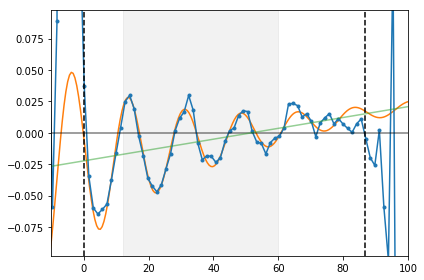

-------------- 5.0 --------------
Inv Decay Length [1/um] 	 0.0208 +- 0.00327
Wavelength [um] 	 18.1 +- 0.218
Amplitude at Wall 	 0.0434 +- 0.00444
Phase at Wall 	 2.97 +- 0.134
Offset           	 -0.00321 +- 0.00217
Gradient          	 -5.54e-06 +- 5.59e-05

Speed of Sound   12.70 +- 0.15 um/ms
Decay Rate Gamma 41.97 +- 6.62 Hz


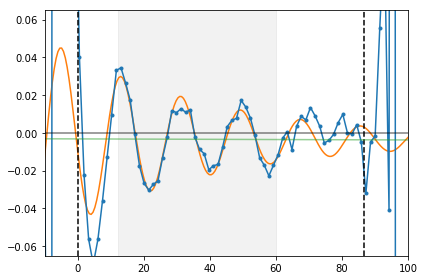

-------------- 10.0 --------------
Inv Decay Length [1/um] 	 0.0273 +- 0.00344
Wavelength [um] 	 17.8 +- 0.21
Amplitude at Wall 	 0.0596 +- 0.00588
Phase at Wall 	 3.36 +- 0.124
Offset           	 -0.0214 +- 0.00238
Gradient          	 0.000415 +- 6.17e-05

Speed of Sound   12.49 +- 0.15 um/ms
Decay Rate Gamma 54.30 +- 6.88 Hz


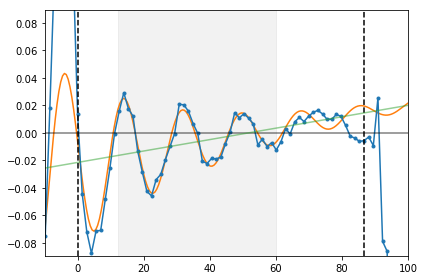

-------------- 15.0 --------------
Inv Decay Length [1/um] 	 0.0382 +- 0.00527
Wavelength [um] 	 17.8 +- 0.328
Amplitude at Wall 	 0.0756 +- 0.0103
Phase at Wall 	 3.45 +- 0.182
Offset           	 -0.00375 +- 0.00317
Gradient          	 -5.79e-05 +- 8.04e-05

Speed of Sound   12.46 +- 0.23 um/ms
Decay Rate Gamma 75.76 +- 10.54 Hz


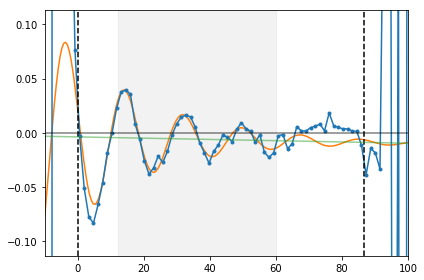

-------------- 20.0 --------------
Inv Decay Length [1/um] 	 0.03 +- 0.00532
Wavelength [um] 	 18.3 +- 0.292
Amplitude at Wall 	 0.0543 +- 0.00825
Phase at Wall 	 3.55 +- 0.158
Offset           	 0.00586 +- 0.00281
Gradient          	 -0.000216 +- 7.15e-05

Speed of Sound   12.78 +- 0.20 um/ms
Decay Rate Gamma 61.03 +- 10.88 Hz


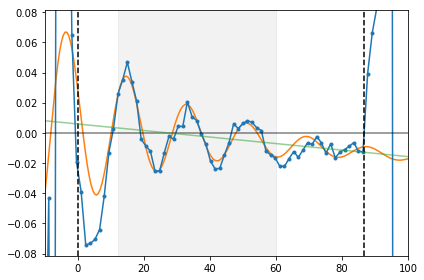

-------------- 25.0 --------------
Inv Decay Length [1/um] 	 0.0339 +- 0.00437
Wavelength [um] 	 18.3 +- 0.249
Amplitude at Wall 	 0.076 +- 0.00906
Phase at Wall 	 3.57 +- 0.134
Offset           	 -0.00965 +- 0.00288
Gradient          	 0.000151 +- 7.35e-05

Speed of Sound   12.83 +- 0.17 um/ms
Decay Rate Gamma 69.27 +- 8.97 Hz


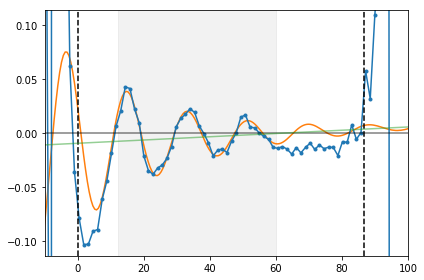

-------------- 30.0 --------------
Inv Decay Length [1/um] 	 0.0298 +- 0.00503
Wavelength [um] 	 18.7 +- 0.258
Amplitude at Wall 	 0.0655 +- 0.00948
Phase at Wall 	 3.63 +- 0.135
Offset           	 -0.0156 +- 0.00308
Gradient          	 0.000248 +- 7.85e-05

Speed of Sound   13.07 +- 0.18 um/ms
Decay Rate Gamma 61.92 +- 10.50 Hz


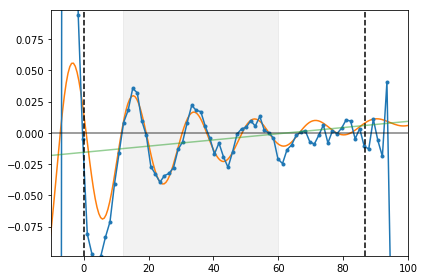

-------------- 35.0 --------------
Inv Decay Length [1/um] 	 0.0244 +- 0.00377
Wavelength [um] 	 18.8 +- 0.183
Amplitude at Wall 	 0.0485 +- 0.00551
Phase at Wall 	 3.67 +- 0.0987
Offset           	 -0.0204 +- 0.00202
Gradient          	 0.000394 +- 5.2e-05

Speed of Sound   13.13 +- 0.13 um/ms
Decay Rate Gamma 50.90 +- 7.88 Hz


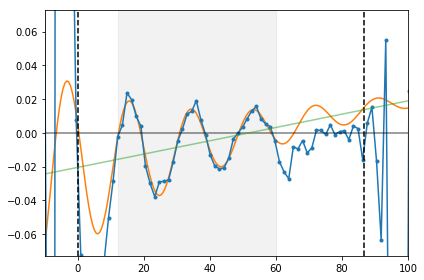

-------------- 40.0 --------------
Inv Decay Length [1/um] 	 0.0312 +- 0.00428
Wavelength [um] 	 19.0 +- 0.206
Amplitude at Wall 	 0.0637 +- 0.00782
Phase at Wall 	 3.76 +- 0.101
Offset           	 -0.00451 +- 0.00234
Gradient          	 -1.19e-05 +- 5.94e-05

Speed of Sound   13.32 +- 0.14 um/ms
Decay Rate Gamma 66.22 +- 9.10 Hz


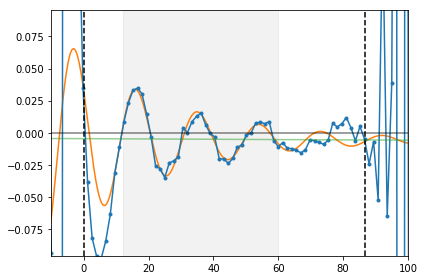

-------------- 45.0 --------------
Inv Decay Length [1/um] 	 0.0334 +- 0.00422
Wavelength [um] 	 19.7 +- 0.217
Amplitude at Wall 	 0.0702 +- 0.00843
Phase at Wall 	 3.67 +- 0.0962
Offset           	 -0.0164 +- 0.00239
Gradient          	 0.00027 +- 6.07e-05

Speed of Sound   13.80 +- 0.15 um/ms
Decay Rate Gamma 73.41 +- 9.30 Hz


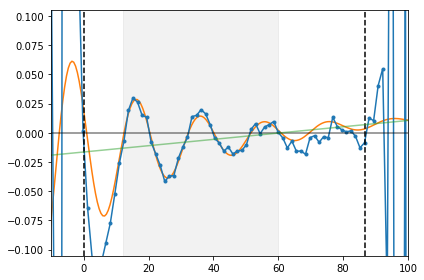

-------------- 50.0 --------------
Inv Decay Length [1/um] 	 0.0373 +- 0.00391
Wavelength [um] 	 20.4 +- 0.233
Amplitude at Wall 	 0.0758 +- 0.00831
Phase at Wall 	 3.63 +- 0.0914
Offset           	 -0.0136 +- 0.00219
Gradient          	 0.000231 +- 5.59e-05

Speed of Sound   14.28 +- 0.16 um/ms
Decay Rate Gamma 84.77 +- 8.93 Hz


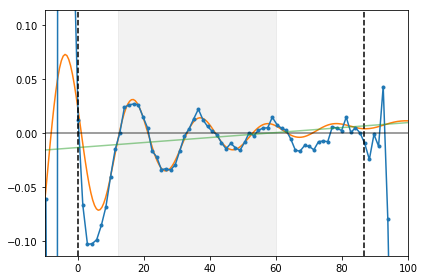

-------------- 55.0 --------------
Inv Decay Length [1/um] 	 0.0242 +- 0.00621
Wavelength [um] 	 20.2 +- 0.371
Amplitude at Wall 	 0.0569 +- 0.0112
Phase at Wall 	 3.92 +- 0.165
Offset           	 -0.0175 +- 0.00417
Gradient          	 0.000382 +- 0.000108

Speed of Sound   14.14 +- 0.26 um/ms
Decay Rate Gamma 54.49 +- 14.01 Hz


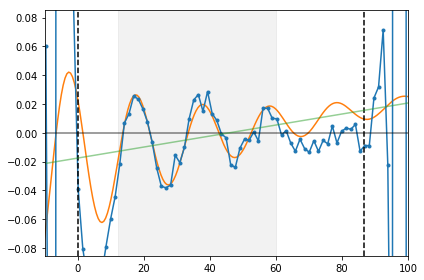

-------------- 60.0 --------------
Inv Decay Length [1/um] 	 0.0387 +- 0.00436
Wavelength [um] 	 21.0 +- 0.276
Amplitude at Wall 	 0.075 +- 0.00916
Phase at Wall 	 3.59 +- 0.102
Offset           	 -0.00735 +- 0.00229
Gradient          	 9.98e-05 +- 5.79e-05

Speed of Sound   14.67 +- 0.19 um/ms
Decay Rate Gamma 90.48 +- 10.26 Hz


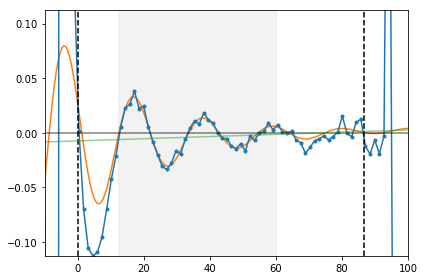

-------------- 65.0 --------------
Inv Decay Length [1/um] 	 0.0304 +- 0.00784
Wavelength [um] 	 20.9 +- 0.5
Amplitude at Wall 	 0.0551 +- 0.013
Phase at Wall 	 3.66 +- 0.201
Offset           	 -0.0145 +- 0.00409
Gradient          	 0.000302 +- 0.000104

Speed of Sound   14.60 +- 0.35 um/ms
Decay Rate Gamma 70.62 +- 18.30 Hz


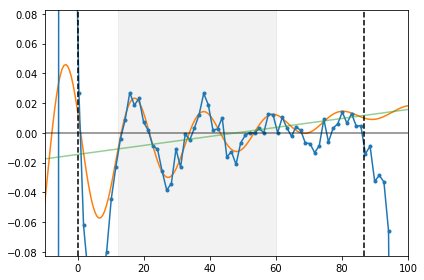

-------------- 70.0 --------------
Inv Decay Length [1/um] 	 0.0318 +- 0.00425
Wavelength [um] 	 22.3 +- 0.292
Amplitude at Wall 	 0.0727 +- 0.00914
Phase at Wall 	 3.47 +- 0.104
Offset           	 -0.00437 +- 0.00266
Gradient          	 0.000102 +- 6.66e-05

Speed of Sound   15.64 +- 0.20 um/ms
Decay Rate Gamma 79.15 +- 10.62 Hz


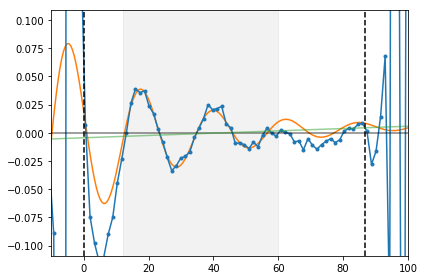

-------------- 75.0 --------------
Inv Decay Length [1/um] 	 0.0241 +- 0.00601
Wavelength [um] 	 21.5 +- 0.386
Amplitude at Wall 	 0.0582 +- 0.0112
Phase at Wall 	 3.87 +- 0.156
Offset           	 -0.00545 +- 0.00399
Gradient          	 8.31e-05 +- 0.000102

Speed of Sound   15.08 +- 0.27 um/ms
Decay Rate Gamma 57.85 +- 14.47 Hz


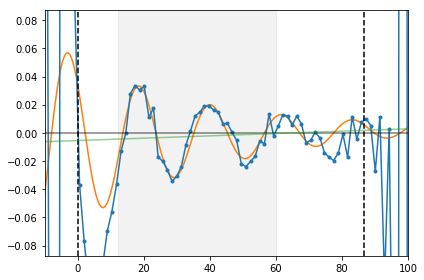

-------------- 80.0 --------------
Inv Decay Length [1/um] 	 0.0401 +- 0.00555
Wavelength [um] 	 22.2 +- 0.363
Amplitude at Wall 	 0.0897 +- 0.0139
Phase at Wall 	 3.89 +- 0.117
Offset           	 -0.0239 +- 0.00317
Gradient          	 0.000512 +- 7.93e-05

Speed of Sound   15.54 +- 0.25 um/ms
Decay Rate Gamma 99.11 +- 13.82 Hz


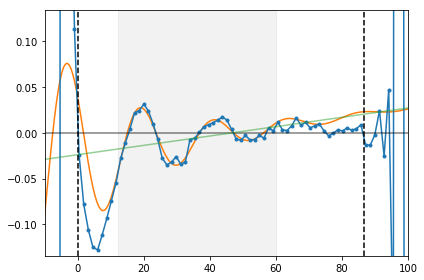

-------------- 90.0 --------------
Inv Decay Length [1/um] 	 0.0305 +- 0.00475
Wavelength [um] 	 22.8 +- 0.33
Amplitude at Wall 	 0.0651 +- 0.00939
Phase at Wall 	 3.87 +- 0.112
Offset           	 -0.0141 +- 0.00275
Gradient          	 0.000295 +- 6.86e-05

Speed of Sound   15.95 +- 0.23 um/ms
Decay Rate Gamma 77.40 +- 12.10 Hz


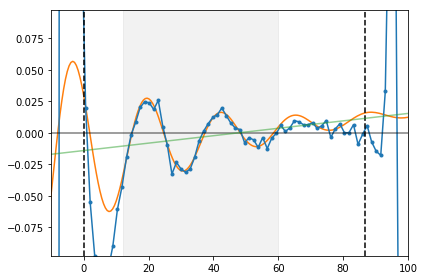

In [181]:
# Fit and plot all data 
frs = []
fes = []

for x, r in df_data.iterrows():
    print('-------------- {} --------------'.format(x))
    c = tp.Curve(r[use].x*1e6, r[use].y)
    fr, fe = single_analyzer(c, r.freq, fit_lims, speed_sound_guess / r.freq * 1e6, True, plot_lims, False,)
    frs.append(fr)
    fes.append(fe)
    plt.show()
    
frs = np.array(frs)
fes = np.array(fes) 

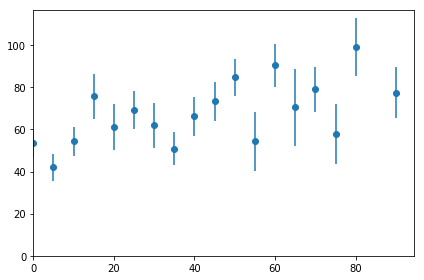

In [182]:
# Plot Raw Results 
plot_res = 7

scales = [1, 1, 1, np.pi, 1, 1, 1e-3, twopi]
plt.errorbar(df_data.index.values, frs[:, plot_res]/scales[plot_res], fes[:, plot_res]/scales[plot_res], fmt='o',)
plt.ylim([0, None])
plt.xlim([0, None])
plt.tight_layout()

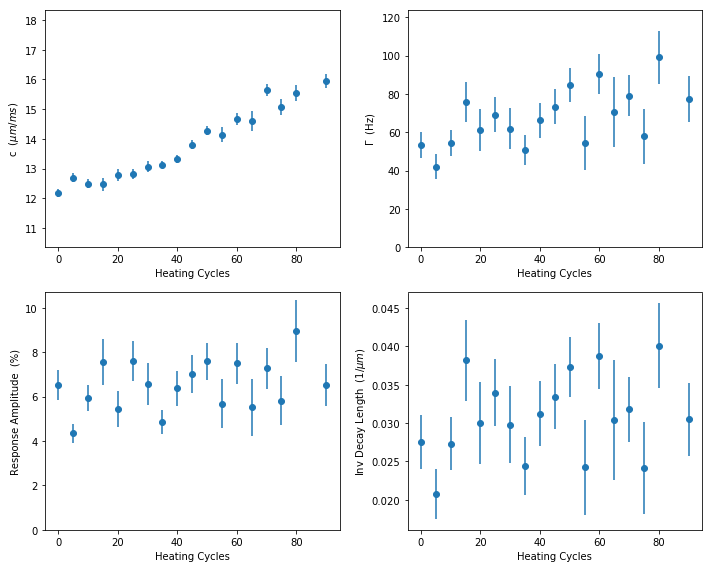

In [183]:
# Plot various things 
c_lim = [0.85*np.min(frs[:, 6]*1e3), 1.15*np.max(frs[:, 6]*1e3)]
g_lim = [0, 1.25*np.max(frs[:, 7]/twopi)]
l_lim = [None, None]
x_lim = [36, 53]
x_lim = [None, None]
xlabel = WID_xlabel.value

x = df_data.index.values
amp_mult = 100
xp = frs[:, 2]*amp_mult

fig, ax = plt.subplots(ncols=2, nrows=2, figsize=[10, 8])
ax = ax.flatten()

ax[0].errorbar(x, frs[:, 6]*1e3, fes[:, 6]*1e3, fmt='o')
ax[0].set(ylabel=r'c  ($\mu m / ms$)', xlim=x_lim, ylim=c_lim, xlabel=xlabel)

ax[1].errorbar(x, frs[:, 7]/twopi, fes[:, 7]/twopi, fmt='o')
ax[1].set(ylabel=r'$\Gamma$  (Hz)', xlim=x_lim, ylim=g_lim, xlabel=xlabel)

ax[2].errorbar(x, frs[:, 2]*amp_mult, fes[:, 2]*amp_mult, fmt='o')
ax[2].set(ylabel=r'Response Amplitude  (%)', xlim=x_lim, ylim=[0, None], xlabel=xlabel)

ax[3].errorbar(x, frs[:, 0], fes[:, 0], fmt='o')
ax[3].set(ylabel=r'Inv Decay Length  (1/$\mu m$)', ylim=l_lim, xlim=x_lim, xlabel=xlabel, )

plt.tight_layout()

In [184]:
# Add results to df_data 
df_data['k'] = twopi / (frs[:, 1] * 1e-6)
df_data['k error'] = twopi / (frs[:, 1] * 1e-6)**2 * (fes[:, 1] * 1e-6)
df_data['omega'] = df_data.freq * twopi


# Getting Temperature 

In [31]:
# Used Functions 

def compute_moment(nz, zlim=550):
    using = (nz.x >= -zlim*1e-6) & (nz.x <= zlim*1e-6)
    nz = tp.Curve(nz.x[using], nz.y[using])
    return np.trapz(nz.y*nz.x**2, nz.x) / np.trapz(nz.y, nz.x)

def gaussian_fit_sigma(nz, plot=False):
    guess = [1e-6, 20e-6, nz.maxy, nz.maxy/1000]
    fr = nz.fit(gaussian, guess, plot=plot)[0]
    res = np.sum((nz.y - gaussian(nz.x, *fr))**2)
    return (fr[1], res)

def erf(x, x0, sigma):
    return scipy.special.erf((x-x0)/(2**0.5 * sigma))
def fitfun_erf(x, amp, x0, sigma):
    return erf(x, x0, sigma) * amp

def compute_moment_v2(nz, cutoff, plot=False, ax = None):
    # Compute moment vs cutoffs
    zlims = np.linspace(cutoff[0], cutoff[2], 100)
    moment = np.array([abs(compute_moment(nz, zlim=z)) for z in zlims])**0.5 * 1e6
    c_ = tp.Curve(zlims, moment)
    c_.removenan()
    
    # Fit
    sigma = c_.x**2/cutoff[1]**2
    sigma[c_.x <= cutoff[1]] = 1
    fr1 = scipy.optimize.curve_fit(fitfun_erf, c_.x, c_.y, p0=[55, 0, 50])[0]
    fr2 = scipy.optimize.curve_fit(fitfun_erf, c_.x, c_.y, p0=fr1, sigma=sigma)[0]
    
    # plot
    if plot:
        if ax is None: ax = plt.subplots()[1]
        ax.plot(*c_.data)
        ax.plot(c_.x, fitfun_erf(c_.x, *fr1), '-.', label='w/o')
        ax.plot(c_.x, fitfun_erf(c_.x, *fr2), label='w/')
        ax.plot(c_.x, 1/sigma * np.mean([fr1[0], fr2[0]]), 'k--', alpha=0.2, label='weight')
        ax.set(ylim=[c_.y.mean() * 0.6, c_.maxy*1.1])
        ax.legend(loc=2)
    
    # return
    return (fr2[0]*1e-6)**2

In [52]:
# # One Time Setup 
# df_energy_all = get_from_clipboard(init=True)

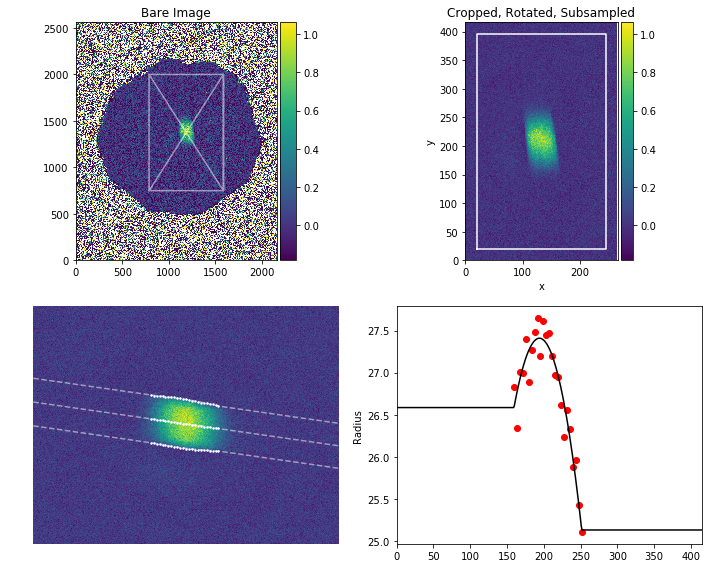

In [53]:
# Load Images 

# Load Images
var = ['ExpansionTime','SideGreenEvap','WaitBox','IREvap','HeatTime','BoxShakeTime', 'ShakingCycles', 'BoxShakeAmp', 'BoxShakeFreq', 'Axial Grad Volt', 'SeqMode']
x_var = 'HeatCycles'
df_energy_all = get_from_clipboard(df=df_energy_all, x_var = x_var, image_func=tp.Hybrid_Image, var=var, using=0, display=False)
df_energy_all.reset_index(drop=True, inplace=True)
# Crop images
settings = {**default_settings, 
            **dict(center_x = 1187, center_y = 1375, width = 800, height = 1250, fudge = 1.75)}
for i, r in df_energy_all.iterrows(): r.image.set(**settings)

# Test
test = 0
ax = plt.subplots(ncols=2, nrows=2, figsize=(10, 8))[1].flatten()
df_energy_all.image.iloc[test].plot_crop(ax=ax[0:2])
ax[1].set(xlabel='x', ylabel='y')
# ax[2].plot(*df_energy_all.image.iloc[test].nz.plotdata)
# ax[2].set(xlabel='z [um]', ylabel='Density n [um^-3]')
df_energy_all.image.iloc[test].xsec.infoplot(axs = [ax[2],ax[3]])
plt.tight_layout()
plt.show()

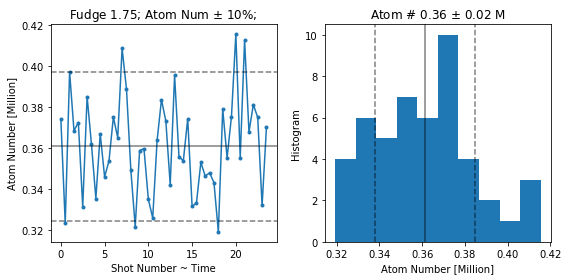

In [82]:
# Atom Number Filter 

# Parameters 
display(WID_atoms_keep)
df_energy_all['total_atoms'] = [im.total_atoms for im in tqdm(df_energy_all.image, desc='Atoms')]
using = atom_num_filter(df_energy_all, keep=0.20, offset=0.0, plot=False)
df_energy = df_energy_all[using]

def makeplot_atomnum_time(ax, df_energy_all=df_energy_all, using=using):
    ax.plot(df_energy_all.shot, df_energy_all.total_atoms/1e6, 'C0.-', 
            df_energy_all[~using].shot, df_energy_all[~using].total_atoms/1e6, 'rx')
    median_atom_num = np.median(df_energy_all.total_atoms) / 1e6
    ax.axhline(median_atom_num, linestyle='-', c='k', alpha=0.5)
    ax.axhline(median_atom_num * (1 + WID_atoms_keep.value), linestyle='--', c='k', alpha=0.5)
    ax.axhline(median_atom_num * (1 - WID_atoms_keep.value), linestyle='--', c='k', alpha=0.5)
    ax.set(xlabel='Shot Number ~ Time', ylabel='Atom Number [Million]', 
              title='Fudge {}; Atom Num $\pm$ {:.0f}%;'.format(df.image.iloc[0].fudge, WID_atoms_keep.value*100))

def makeplot_atomnum_hist(ax, df=df):
    ax.hist(df.total_atoms/1e6)
    mean_atom_num = np.mean(df.total_atoms)/1e6
    std_atom_num = np.std(df.total_atoms)/1e6
    ax.axvline(mean_atom_num, linestyle='-', c='k', alpha=0.5)
    ax.axvline(mean_atom_num + std_atom_num, linestyle='--', c='k', alpha=0.5)
    ax.axvline(mean_atom_num - std_atom_num, linestyle='--', c='k', alpha=0.5)
    ax.set(xlabel='Atom Number [Million]', ylabel='Histogram', title='Atom # {:.2f} $\pm$ {:.2f} M'.format(mean_atom_num, std_atom_num))

fig, ax = plt.subplots(ncols=2, figsize=[8, 4])
makeplot_atomnum_time(ax[0], df_energy_all, using)
makeplot_atomnum_hist(ax[1], df_energy)
plt.tight_layout()

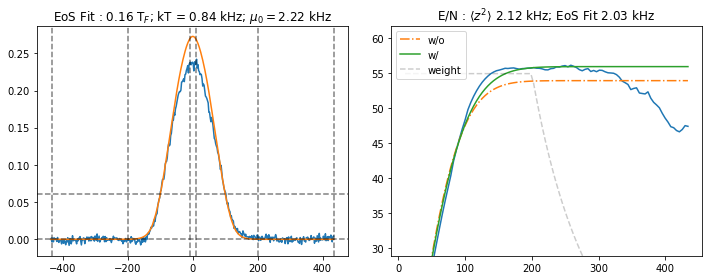

In [83]:
# Test Temperature Fits and Second Moment Limits 

zlim_second_moment = np.array([10, 200, df_energy.image.iloc[0].nz.maxx*1e6])
kHz = 1e3 * cst.h
prefactor = 2 * cst.mass * df_energy.image.iloc[0].trap_w**2

# Test function
def test_func(test=0, ):
    # Get the image and compute it all 
    im = df_energy.image.iloc[test]
    im.T_kHz
    
    # Second moment
    nz = im.nz
    moment = compute_moment_v2(nz, zlim_second_moment)**0.5 * 1e6
    E_N_moment = prefactor * (moment*1e-6)**2 / kHz
    
    # Temperature
    Tfit_info = im.var['Tfit_info']
    nz_fit = tp.Curve(nz.x, Tfit_info[0](nz.x, *Tfit_info[1]), xscale=nz.xscale, yscale = nz.yscale)
    E_N_fit = hybrid_E_N(im.T_kHz * kHz, im.mu0_kHz * kHz, im.trap_f) / kHz
    
    # Plots
    print(df_energy.x.iloc[test])
    fig, ax = plt.subplots(ncols=2, figsize=(10, 4))
    ax[0].plot(*nz.plotdata)
    ax[0].plot(*nz_fit.plotdata)
    ax[0].axhline(im.Tfit_lim, linestyle='--', c='k', alpha=0.5)
    ax[0].axhline(0, linestyle='--',c='k',alpha=0.5)
    for _ in [*zlim_second_moment, *-zlim_second_moment]: ax[0].axvline(_, linestyle='--',c='k',alpha=0.5)
    compute_moment_v2(nz, zlim_second_moment, plot=True, ax=ax[1])
    ax[0].set(title='EoS Fit : {:.2f} T$_F$; kT = {:.2f} kHz; $\mu_0=${:.2f} kHz'.format(im.TTF_center, im.T_kHz, im.mu0_kHz) )
    ax[1].set(title=r"E/N : $\left< z^2 \right>$ {:.2f} kHz; EoS Fit {:.2f} kHz".format(E_N_moment, E_N_fit))
    fig.tight_layout()

if df_energy.shape[0] == 1:
    test_func(0)
else:
    ipywidgets.interact(test_func, test=(0, df_energy.shape[0]-1, 1));

In [84]:
# Box Characteristics !!! CRUCIAL 

# Cross section for calculating EoS fit atom numebrs 
cross_section=np.pi*(57.94e-6)**2

# Box Volume for calculating E_F box 
box_volume = 87.80e-6 * cross_section



        Total Loaded Images 48
        Atom Num Filter     48
        Removed Images      0
        


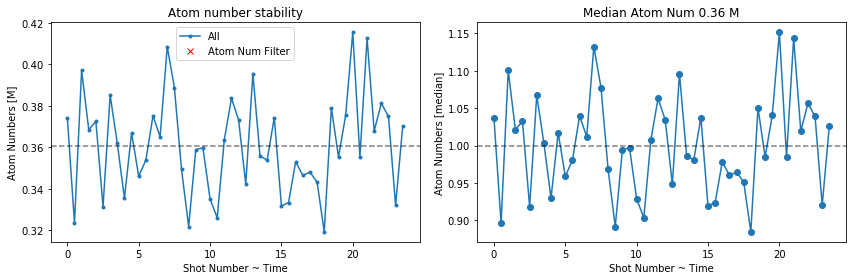

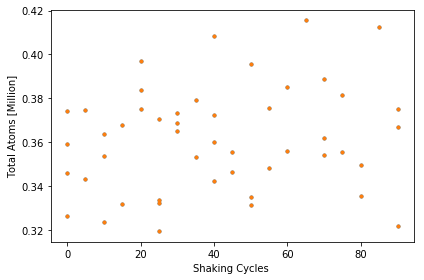

In [85]:
# fit and bin all data 

# Atom Number Filter
df_energy['total_atoms'] = np.array([np.nansum(im.app) for im in tqdm(df_energy.image, desc='Atoms')])
using = atom_num_filter(df_energy, keep=0.40, offset=0.0)
plt.show()

# using = using & (df_energy['ShakingCycles'].values != 0)
# print('Removed BG Images {}'.format(np.sum(using)))

# Compute E/N for good images
EN_eos = np.array([hybrid_E_N(im.T_kHz * kHz, im.mu0_kHz * kHz, im.trap_f) for im in tqdm(df_energy.image[using], desc='EoS')])
EN_moment = np.array([prefactor * compute_moment_v2(im.nz, zlim_second_moment) for im in tqdm(df_energy.image[using], desc='Moment')])
temp_eos_atoms = np.array([hybrid_total_atoms(im.T_kHz * kHz, im.mu0_kHz * kHz, im.trap_f, cross_section) for im in tqdm(df_energy.image[using], desc='EoS')])

# Bin Data
EN_eos = bin_data(df_energy.x.values[using], EN_eos)
EN_moment = bin_data(df_energy.x.values[using], EN_moment)
total_atoms = bin_data(df_energy.x.values[using], df_energy.total_atoms.values[using])
total_atoms_fit = bin_data(df_energy.x.values[using], temp_eos_atoms)

# Plot atoms vs x 
plt.figure()
plt.plot(df_energy.x, df_energy.total_atoms/1e6,'.')
plt.plot(df_energy.x[using], df_energy.total_atoms[using]/1e6,'.')
# plt.xlabel('Shaking Frequency [Hz]')
plt.xlabel('Shaking Cycles ')
plt.ylabel('Total Atoms [Million]')
plt.tight_layout()

In [86]:
# Information about the data 
unique, counts = np.unique(total_atoms[4], return_counts=True)
for i in range(unique.size):
    print(unique[i], '--', counts[i])

0.0 -- 4
5.0 -- 2
10.0 -- 3
15.0 -- 2
20.0 -- 3
25.0 -- 4
30.0 -- 3
35.0 -- 2
40.0 -- 4
45.0 -- 2
50.0 -- 3
55.0 -- 2
60.0 -- 2
65.0 -- 1
70.0 -- 3
75.0 -- 2
80.0 -- 2
85.0 -- 1
90.0 -- 3


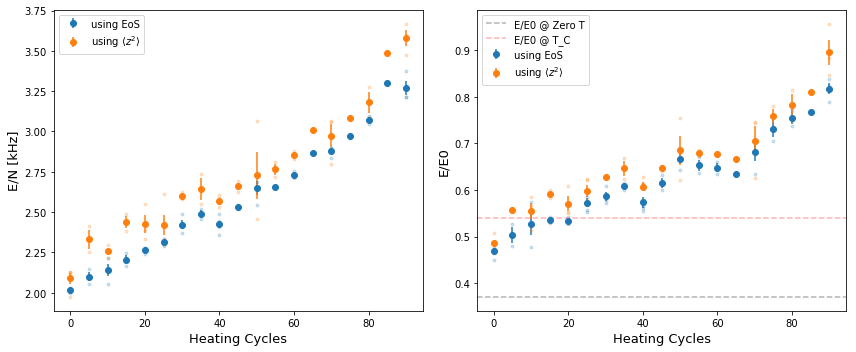

In [87]:
# Simple Plot : E/N and E/E0 vs x_variable 
# xlabel = 'Wait time [s]'
# xlabel = 'Freq [Hz]'
xlabel = 'Heating Cycles'
# xlabel = 'Expansion Time [ms]'
ylabel = 'E/N [kHz]'
fontsize = 13

plt.figure(figsize=[12, 5])
plt.subplot(121)
plt.errorbar(EN_eos[0], EN_eos[1]/kHz, yerr=EN_eos[2]/kHz, fmt='oC0', label='using EoS')
plt.plot(EN_eos[4], EN_eos[5]/kHz, '.C0', alpha=0.2)
plt.errorbar(EN_moment[0], EN_moment[1]/kHz, yerr=EN_moment[2]/kHz, fmt='oC1', label = r'using $\left< z^2 \right>$')
plt.plot(EN_moment[4], EN_moment[5]/kHz, '.C1', alpha=0.2)
plt.xlabel(xlabel, fontsize=fontsize)
plt.ylabel(ylabel, fontsize=fontsize)
plt.legend()

plt.subplot(122)
E_E0 = 5/3 * EN_eos[5] / cst.n2EF(total_atoms_fit[5] / box_volume)
E_E0_eos = bin_data(EN_eos[4], E_E0)
plt.errorbar(*E_E0_eos[0:3], fmt='o', label='using EoS')
plt.plot(E_E0_eos[4], E_E0_eos[5], '.C0', alpha=0.2)
E_E0 = 5/3 * EN_moment[5] / cst.n2EF(total_atoms_fit[5] / box_volume)
E_E0_moment = bin_data(EN_moment[4], E_E0)
plt.errorbar(*E_E0_moment[0:3], fmt='o', label=r'using $\left< z^2 \right>$')
plt.plot(E_E0_moment[4], E_E0_moment[5], '.C1', alpha=0.2)
plt.axhline(0.37, linestyle='--', color='k', alpha=0.3, label='E/E0 @ Zero T')
plt.axhline(0.54, linestyle='--', color='r', alpha=0.3, label='E/E0 @ T_C')
plt.ylabel('E/E0', fontsize=fontsize)
plt.xlabel(xlabel, fontsize=fontsize)
# plt.xlim([0, None])
plt.legend()
plt.tight_layout()


Fudge : 1.75
Box Volume : 925979 um^3
T/TF from EoS fit : 0.144
Fermi Energy : 6.816 +- 0.296 kHz
E/N from EoS fit  : 2.015 +- 0.006
E/N from moment   : 2.089 +- 0.034
E/E0 from EoS fit : 0.468 +- 0.006
E/E0 from moment  : 0.485 +- 0.007


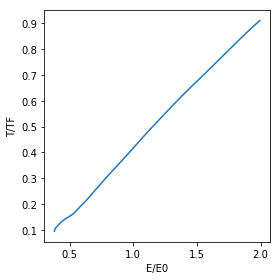

In [88]:
# print some info 
print('Fudge : {}'.format(df_energy.image.iloc[0].fudge))
print('Box Volume : {:.0f} um^3'.format(box_volume*1e18))
c = tp.Curve(UFG.df['E/E0'].values, UFG.df['T/T_F'].values)
print("T/TF from EoS fit : {:.3f}".format(c(E_E0_eos[1][0])))
print('Fermi Energy : {:.3f} +- {:.3f} kHz'.format(cst.n2EFHz(np.mean(total_atoms[5])/box_volume)/1e3, np.std(cst.n2EFHz(np.array(total_atoms[5])/box_volume)/1e3)))
print("E/N from EoS fit  : {:.3f} +- {:.3f}".format(EN_eos[1][0]/kHz, EN_eos[2][0]/kHz))
print("E/N from moment   : {:.3f} +- {:.3f}".format(EN_moment[1][0]/kHz, EN_moment[2][0]/kHz))
print("E/E0 from EoS fit : {:.3f} +- {:.3f}".format(E_E0_eos[1][0], E_E0_eos[2][0]))
print("E/E0 from moment  : {:.3f} +- {:.3f}".format(E_E0_moment[1][0], E_E0_moment[2][0]))

plt.figure(figsize=[4,4])
plt.plot(*c.trim(xlim=[0, 2]).plotdata)
plt.xlabel('E/E0')
plt.ylabel('T/TF')
plt.tight_layout()

# Plots

In [185]:
energy = [EN_eos[0], EN_eos[1]/kHz, EN_eos[2]/kHz]
df_data['E/N'] = None
df_data['E/N Error'] = None
for i, r in df_data.iterrows():
    loc = np.argmin(np.abs(energy[0]-i))
    df_data.loc[i, 'E/N'] = energy[1][loc]
    df_data.loc[i, 'E/N Error'] = energy[2][loc]

      FitValue    FitError Units  Guess  LowerBound  UpperBound   FitError%
a1  194.196425   51.858023  None      1        -inf         inf   26.703902
a0  -68.667415  126.734455  None      0        -inf         inf  184.562730


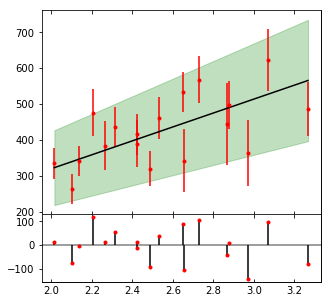

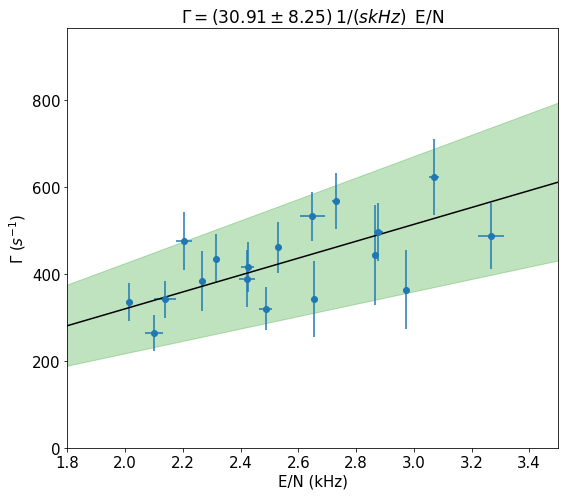

In [234]:
# Plot 
gamma = [df_data.index.values, frs[:, 7], fes[:, 7]]
energy = [df_data.index.values, df_data['E/N'].values, df_data['E/N Error'].values]
gamma_energy = [energy[1], gamma[1], energy[2], gamma[2]]
for i, g in enumerate(gamma_energy):
    gamma_energy[i] = np.array(g, dtype=np.float)

def poly1(x, a1=0, a0=0): return a0 + a1*x
fit = Curve_Fit(poly1, [1, 0], gamma_energy[0], gamma_energy[1], gamma_energy[3], info=True)
fit.plot(fiterrors=True, using=['a1'])

plt.figure(figsize=(8, 7))
plt.errorbar(*gamma_energy[0:2], xerr=gamma_energy[2], yerr=gamma_energy[3], fmt='o')
xp = np.linspace(0, 4)
plt.plot(xp, fit(xp), 'k-')
plt.fill_between(xp, fit(xp, a1 = fit.fv[0]+fit.fe[0]), 
                 fit(xp, a1 = fit.fv[0]-fit.fe[0]), color='C2', alpha=0.3)
plt.ylim([0, None])
plt.xlim([1.8, 3.5])

plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.ylabel(r'$\Gamma$ ($s^{-1}$)', fontsize=15)
plt.xlabel(r'E/N (kHz)', fontsize=15)
plt.title('$\Gamma = ({:.2f} \pm {:.2f}  ) \: 1/(s  kHz) \: $ E/N'.format(fit.fv[0]/twopi, fit.fe[0]/twopi), fontsize=17)

plt.tight_layout()
# plt.savefig('Gamma_Energy_FitError.pdf')
# plt.savefig('Gamma_Energy.pdf')

_ = pd.DataFrame(np.array(gamma_energy).T, columns=['E/N (kHz)', 'Gamma (1/s)', 'E/N Error (kHz)', 'Gamma Error (1/s)'])
_.to_clipboard(excel=True)